<a href="https://colab.research.google.com/github/abrichr/visual-contact-tracing/blob/master/Visual_Contact_Tracing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO

High Priority:
- Extend last frame for 3-4s
- Upscale interactions
- Add intro and outro
- Improve font
- Move numbers inside box
- Audio:

In this video we demonstrate Visual Contact Tracing with AI.

Contact Tracing is a labour intensive process that involves identifying individuals who have had close contact with someone who is infected with a virus. It's an increasingly important tool for "flattening the curve" in the age of COVID-19, but it can involve manually reviewing hours of security camera footage, which is often unfeasible due to time and cost.

We are building a system to allow contact tracing teams to track how infections spread in dense urban environments accurately and at scale by automating this part of the process.

Human input is required to specify the initial source of infection (here it's the man pouring champagne on the right). Infection may spread to a healthy individual via physical contact with an infected one. This is detected automatically by a deep neural network (a form of artificial intelligence, or AI).

Infected individuals are highlighted with rectangles. Interactions which cause the infection to spread are highlighted with circles.

Future work involves re-identifying individuals between videos, and creating a web application to let users upload and analyze their own.

Compared to Bluetooth-based contact tracing, this approach has a few advantages:

- Does not require individuals to have a smartphone or install an app
- Can detect indirect infections via surfaces
- Is opt-in by default
- Does not get fooled by walls (unless they're invisible)

Our goal is to enable accurate contact tracing at scale in areas where security cameras are ubiquitous, like grocery stores, office buildings, schools, hospitals, factories, and public transit.

Inquiries and feedback are welcome! Please email richard.abrich@mldsai.com or visit mldsai.com to get in touch.

Thank you for watching!

Copyright 2020 MLDSAI Inc. All Rights Reserved. http://mldsai.com

---

Backlog:
* Interpolate missing keypoints between frames
* Smooth keypoint positions across frames with optical flow: https://github.com/facebookresearch/DetectAndTrack/blob/d66734498a4331cd6fde87d8269499b8577a2842/lib/core/tracking_engine.py#L600
* Propagate keypoints through frames using optical flow and add to distance matrix: https://arxiv.org/pdf/1804.06208.pdf
* Add bounding box area difference to cost?
* Add legend, frame, params, date to output video
* Hide numbers for non-infected tracks
* Re-number infected tracks
* Inter video tracking
* REST API (POST video/upload, GET video/contacts)
* improve highlight on padded hits (e.g. thick red border, animation)
* detect and blur faces
* Show hits with dotted line
* Predict distance directly from image (literature review)
- Simulate mouseover + click?
- Implement HTML UI
- MLDSAI.com/blog article
- Real time infection tree, grows down with time
        1
       / \
       2 |
         3
        / \
        4 5
- List of infected idxs
- Sneeze detection
- Clarify what this is not (i.e. does not identify individuals, just tracks them anonymously)

## Setup

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1 cython_bbox
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
# get configs
# TODO: can we read this from site-packages?
!git clone https://github.com/facebookresearch/detectron2

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d12cf314de6551708e9095f172adcb4c9ed3d37e72989a398de6830e31b22af9
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
  Created wheel for cython-bbox: filename=cython_bbox-0.1.3-cp36-cp36m-linux_x86_64.whl size=57428 sha256=0faad261bd52505f2b638d363e4b956e6c5772dd40740556c00b0667c04dfd3d
  Stored in directory: /root/.cache/pip/wheels/2b/31/b5/9246d5988e79ef89dc28b894835d2f305e23c1e5f4f80278ee
Successfully built pyyaml cython-bbox
  Found existing installation:

In [0]:
# May need to restart your runtime prior to this to let installation take effect

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
#setup_logger()

import numpy as np
import cv2
import random
from google.colab import files
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog

from scipy.spatial.distance import pdist, squareform
import requests
#import subprocess as sp

import imageio
from cython_bbox import bbox_overlaps
from skimage.color import rgba2rgb

import os
import sys
import time
from tqdm.notebook import tqdm
from detectron2.utils import visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.video_visualizer import VideoVisualizer
import torch
from pprint import pprint, pformat


Upload a video

In [0]:
if 0:
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))
    )

Or load from Google Drive

In [4]:

def download_file_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=$file_id" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$file_id" -o $file_name
  with open(file_name, 'rb') as f:
    data = f.read()
    print('downloaded', len(data), 'bytes to', video_filename)


file_id = '0Bzf1l8WmTwu0eUluQ2h1NWZQRjQ'
video_filename = 'salsa_cpp_cam4.avi'

# TODO: add to run_configs

# file_id = '0Bzf1l8WmTwu0dVpjSUZhVW5GZjQ'
# video_filename = 'salsa_cpp_cam1.avi'

download_file_from_google_drive(file_id, video_filename)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   403    0   403    0     0   4477      0 --:--:-- --:--:-- --:--:--  4477
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  143M    0  143M    0     0  97.7M      0 --:--:--  0:00:01 --:--:--  158M
downloaded 150146578 bytes to salsa_cpp_cam4.avi


## Re-encode

In [5]:
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-person-keypoint-detection-baselines-with-keypoint-r-cnn
CFG_50 = 'keypoint_rcnn_R_50_FPN_3x.yaml'         # 0.066 s/im 55.4 box AP 65.5 kp. AP
CFG_101 = 'keypoint_rcnn_X_101_32x8d_FPN_3x.yaml' # 0.121 s/im 57.3	box AP 66.0 kp. AP


RUN_CONFIGS = [
  # start_time_seconds, duration_seconds, start_infected_track, cfg_name
  (1, 10, 3, CFG_50),
  (10, 9.5, 2, CFG_50),
  (10, 14, 2, CFG_50),
  (1, 19.75, 3, CFG_50),
  (4, 5, 2, CFG_50),
  (0, 25, 1, CFG_101),  # isolated
  (0, 27, 1, CFG_50), # D 25

  #(150, 10, 9, CFG_50),  # second video
  #3:38 : 3:58
  #(218, 20, 15, CFG_50)  # second video
]
run_config = RUN_CONFIGS[-1]
start_time_seconds, duration_seconds, start_infected_track, cfg_name = run_config
print('run_config:', run_config)

ffmpeg = imageio.plugins.ffmpeg                                                
try:                                                                           
    ffmpeg.download()                                                          
except:                                                                        
    pass                                                                       
ffmpeg_exe = ffmpeg.get_exe()

video_path = video_filename
video_filename_reenc = video_filename + '-reenc.avi'

cmd_parts = [
  ffmpeg_exe,
  '-i', video_path,
  '-vcodec', 'h264',
  '-acodec', 'aac',
  #'-c', 'copy',
  '-strict',
  '-2',
  '-ss', str(start_time_seconds),
  '-t', str(duration_seconds),
  '-y',
  '-loglevel', 'debug',
  '-an',
  video_filename_reenc
]
cmd = ' '.join(cmd_parts)
print('Running cmd:\n', cmd)                                
! $cmd                                

with open(video_filename_reenc, 'rb') as f:
  data = f.read()
  print('wrote', len(data), 'bytes')

run_config: (0, 27, 1, 'keypoint_rcnn_R_50_FPN_3x.yaml')
Running cmd:
 /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1 -i salsa_cpp_cam4.avi -vcodec h264 -acodec aac -strict -2 -ss 0 -t 27 -y -loglevel debug -an salsa_cpp_cam4.avi-reenc.avi
ffmpeg version N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.1 (Debian 5.4.1-8) 20170304
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-5 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libass --enable-libfreetype --enable-libfribidi --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --e

## Keypoint Inference

In [6]:
SHOW_NUM_FRAMES = 0
WRITE_KP_OUTPUT = False
HIDE_KEYPOINTS = False
DEFAULT_CONFIG = f'detectron2/configs/COCO-Keypoints/{cfg_name}'
DEFAULT_CONF_THRESH = 0.7
DEFAULT_OPTS = ['MODEL.WEIGHTS', model_zoo.get_checkpoint_url(f'COCO-Keypoints/{cfg_name}')]
# https://github.com/facebookresearch/detectron2/blob/04958b93e1232935e126c2fd9e6ccd3f57c3a8f3/detectron2/utils/visualizer.py#L32
KEYPOINT_THRESHOLD = 0.04
visualizer._KEYPOINT_THRESHOLD = KEYPOINT_THRESHOLD


def setup_cfg(config=DEFAULT_CONFIG, opts=DEFAULT_OPTS, conf_thresh=DEFAULT_CONF_THRESH):
  # load config from file and arguments
  cfg = get_cfg()
  if not torch.cuda.device_count():
    print('Running on CPU')
    cfg.MODEL.DEVICE = 'cpu'
  cfg.merge_from_file(config)
  cfg.merge_from_list(opts)
  # Set score_threshold for builtin models
  cfg.MODEL.RETINANET.SCORE_THRESH_TEST = conf_thresh
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_thresh
  cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = conf_thresh
  cfg.freeze()
  return cfg


setup_logger(name='core')
logger = setup_logger('app')
logger.info(f'arguments: {[DEFAULT_CONFIG, DEFAULT_OPTS, DEFAULT_CONF_THRESH]}')

cfg = setup_cfg()
predictor = DefaultPredictor(cfg)

video_input = video_filename_reenc
print('video_input:', video_input)
assert os.path.isfile(video_input)
video = cv2.VideoCapture(video_input)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
print('frames_per_second:', frames_per_second)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print('num_frames:', num_frames)
basename = os.path.basename(video_input)

kp_output_fname = f'{video_filename_reenc}-kp.mp4'
print('kp_output_fname:', kp_output_fname)
kp_output_file = cv2.VideoWriter(
  filename=kp_output_fname,
  fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
  fps=float(frames_per_second),
  frameSize=(width, height),
  isColor=True,
)

metadata = MetadataCatalog.get(
  cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
)
cpu_device = torch.device('cpu')
instance_mode = ColorMode.IMAGE
video_visualizer = VideoVisualizer(metadata, instance_mode)

def process_predictions(frame, predictions):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  if "panoptic_seg" in predictions:
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    vis_frame = video_visualizer.draw_panoptic_seg_predictions(
      frame, panoptic_seg.to(cpu_device), segments_info
    )
  elif "instances" in predictions:
    predictions = predictions["instances"].to(cpu_device)
    if HIDE_KEYPOINTS:
      predictions.remove('pred_keypoints')
    vis_frame = video_visualizer.draw_instance_predictions(frame, predictions)
  elif "sem_seg" in predictions:
    vis_frame = video_visualizer.draw_sem_seg(
      frame, predictions["sem_seg"].argmax(dim=0).to(cpu_device)
    )

  # Converts Matplotlib RGB format to OpenCV BGR format
  vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
  return vis_frame

def _frame_from_video(video):
  while video.isOpened():
    success, frame = video.read()
    if success:
      yield frame
    else:
      break

frame_gen = _frame_from_video(video)
frames = []
all_predictions = []
for i, frame in enumerate(tqdm(frame_gen, total=num_frames)):

  frames.append(frame)
  start = time.time()
  predictions = predictor(frame)
  all_predictions.append(predictions)

  if i < SHOW_NUM_FRAMES or WRITE_KP_OUTPUT:
    vis_frame = process_predictions(frame, predictions)
    if i < SHOW_NUM_FRAMES:
      print('displaying frame', i)
      cv2_imshow(vis_frame)
    if WRITE_KP_OUTPUT:
      kp_output_file.write(vis_frame)

all_predictions = np.array(all_predictions)
#print('all_predictions.shape:', all_predictions.shape)

video.release()
kp_output_file.release()

if WRITE_KP_OUTPUT:
  with open(kp_output_fname, 'rb') as f:
    print('wrote', len(f.read()), 'bytes to', kp_output_fname)
  files.download(kp_output_fname)

[05/12 02:26:37 detectron2]: arguments: ['detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml', ['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl'], 0.7]


model_final_a6e10b.pkl: 237MB [00:11, 20.7MB/s]                           


video_input: salsa_cpp_cam4.avi-reenc.avi
frames_per_second: 15.0
num_frames: 404
kp_output_fname: salsa_cpp_cam4.avi-reenc.avi-kp.mp4


## Create tracks

In [7]:
DEFAULT_HIDE_KEYPOINTS = True
DEFAULT_HIDE_BOXES = True
SHOW_START_END_FRAMES = 0
# TODO: rename
T = 51
MAX_COST = .99

mean_min_costs = []
max_min_costs = []

# https://github.com/facebookresearch/detectron2/issues/754#issuecomment-579463185
JOINT_NAMES = [
  "nose",
  "left_eye", "right_eye",
  "left_ear", "right_ear",
  "left_shoulder", "right_shoulder",
  "left_elbow", "right_elbow",
  "left_wrist", "right_wrist",
  "left_hip", "right_hip",
  "left_knee", "right_knee",
  "left_ankle", "right_ankle"
]

max_num_instances = 0
all_keypoints = []
all_boxes = []
for predictions in all_predictions:
  #predictions['instances'].get_fields().keys()
  #'pred_boxes', 'scores', 'pred_classes', 'pred_keypoints'
  instances = predictions['instances'].to(cpu_device)
  #import pdb; pdb.set_trace()
  keypoints = np.asarray(instances.pred_keypoints)
  boxes = np.asarray(instances.pred_boxes.tensor)
  #print('keypoints:', keypoints.shape)
  all_keypoints.append(keypoints)
  all_boxes.append(boxes)
  num_instances = keypoints.shape[0]
  max_num_instances = max(max_num_instances, num_instances)
print('max_num_instances:', max_num_instances)
print('len(all_keypoints):', len(all_keypoints))


# https://github.com/facebookresearch/DetectAndTrack/blob/d66734498a4331cd6fde87d8269499b8577a2842/lib/core/tracking_engine.py#L106
def compute_pairwise_iou(a, b):
  """
  a, b (np.ndarray) of shape Nx4 and Mx4.
  The output is NxM, for each combination of boxes.
  """

  C = 1 - bbox_overlaps(
    np.ascontiguousarray(a, dtype=np.float64),
    np.ascontiguousarray(b, dtype=np.float64),
  )
  return C


def compute_distance_matrix(prev_boxes, cur_boxes):
  # TODO: consider keypoint distance?
  # TODO: weigh cost further away in time more heavily
  return compute_pairwise_iou(prev_boxes, cur_boxes)


# https://github.com/facebookresearch/DetectAndTrack/blob/d66734498a4331cd6fde87d8269499b8577a2842/lib/core/tracking_engine.py#L184
def bipartite_matching_greedy(C, prev_tracks):
    """
    Computes the bipartite matching between the rows and columns, given the
    cost matrix, C.
    """
    C = C.copy()  # to avoid affecting the original matrix
    prev_ids = []
    cur_ids = []
    min_costs = []
    while (C == np.inf).sum() != C.size:
      #print('*' * 40)

      # Find the lowest cost element
      min_idx = C.argmin()
      i, j = np.unravel_index(min_idx, C.shape)
      min_val = C[i][j]
      #print('min_idx:', min_idx, 'min_val:', min_val, 'i:', i, 'j:', j)

      # Add to results
      min_cost = C.min()
      min_costs.append(min_cost)
      #print('adding to results:')
      prev_ids.append(i)
      if (not MAX_COST) or (min_cost < MAX_COST):
        cur_ids.append(j)
      else:
        cur_ids.append(-1)
      #print('prev_ids:', prev_ids)
      #print('cur_ids:', cur_ids)
      
      # Remove from cost matrix
      track = prev_tracks[i]
      #print('track:', track)
      track_idxs = [
        idx for idx in range(len(prev_tracks))
        if prev_tracks[idx] == track
      ]
      #print('track_idxs:', track_idxs)
      C[:, j] = np.inf
      for track_idx in track_idxs:
        #print('removing track_idx:', track_idx)
        C[track_idx, :] = np.inf
      #num_removed_costs = (C == np.inf).sum()
      #print('num_removed_costs:', num_infs)

    mean_min_cost = np.mean(min_costs)
    mean_min_cost_idx = np.argmin(min_costs)
    mean_min_cost_track = cur_ids[mean_min_cost_idx]
    if mean_min_cost_track == -1:
      max_min_cost_track = next_track_id[0]
    #print('mean_min_cost:', mean_min_cost)
    mean_min_costs.append((mean_min_cost, mean_min_cost_track))

    max_min_cost = np.max(min_costs)
    max_min_cost_idx = np.argmax(min_costs)
    max_min_cost_track = cur_ids[max_min_cost_idx]
    if max_min_cost_track == -1:
      max_min_cost_track = next_track_id[0]
    #print('max_min_cost:', max_min_cost)
    max_min_costs.append((max_min_cost, max_min_cost_track))

    return prev_ids, cur_ids


def compute_matches(prev_boxes, cur_boxes, prev_tracks):
  assert len(prev_boxes) == len(prev_tracks)
  #matches = -np.ones((max_num_instances, ), dtype=np.int32)
  matches = -np.ones((len(cur_boxes), ), dtype=np.int32)
  if not prev_boxes.size:
    return matches
  C = compute_distance_matrix(prev_boxes, cur_boxes)
  prev_inds, next_inds = bipartite_matching_greedy(C, prev_tracks)
  #print('prev_inds:', prev_inds, len(prev_inds))
  #print('next_inds:', next_inds, len(next_inds))
  assert(len(prev_inds) == len(next_inds))
  for i in range(len(prev_inds)):
    #print('i:', i, 'next_inds[i]:', next_inds[i], 'prev_inds[i]', prev_inds[i])
    matches[next_inds[i]] = prev_inds[i]
    #print('matches:', matches)
  return matches


def get_frame_tracks(matches, prev_tracks, next_track_id):
  frame_tracks = []
  for i, m in enumerate(matches):
    #print('i:', i, 'm:', m, 'len(prev_tracks):', len(prev_tracks ))
    if m == -1 or m >= len(prev_tracks):  # didn't match to any
      frame_tracks.append(next_track_id[0])
      next_track_id[0] += 1
    else:
      frame_tracks.append(prev_tracks[m])
  #print('prev_tracks:\t', prev_tracks, 'len(prev_tracks):', len(prev_tracks))
  #print('frame_tracks:\t', frame_tracks, 'len(frame_tracks):', len(frame_tracks))
  return frame_tracks


def visualize_predictions(frame, instances, hide_keypoints=DEFAULT_HIDE_KEYPOINTS, hide_boxes=DEFAULT_HIDE_BOXES):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    if hide_keypoints or hide_boxes:
      # make a copy
      instances = instances.to(cpu_device)
    if hide_keypoints:
      instances.remove('pred_keypoints')
    if hide_boxes:
      instances.pred_boxes.tensor = torch.Tensor()
    # https://github.com/facebookresearch/detectron2/blob/master/detectron2/utils/video_visualizer.py#L53
    # https://github.com/facebookresearch/detectron2/blob/b6fe828a2f3b2133f24cb93c1d0d74cb59c6a15d/detectron2/utils/video_visualizer.py#L53
    vis_frame = video_visualizer.draw_instance_predictions(frame, instances)
    # Converts Matplotlib RGB format to OpenCV BGR format
    vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
    return vis_frame


# compute tracks, inspired by:
# https://github.com/facebookresearch/DetectAndTrack/blob/d66734498a4331cd6fde87d8269499b8577a2842/lib/core/tracking_engine.py#L272
all_prev_boxes = []
video_tracks = []
next_track_id = [0]
for frame_id, (frame, predictions) in enumerate(tqdm(zip(frames, all_predictions), total=len(frames))):
  #print('\nframe_id:', frame_id)

  instances = predictions['instances'].to(cpu_device)  
  cur_boxes = np.asarray(instances.pred_boxes.tensor)
  prev_boxes = np.vstack(all_prev_boxes) if all_prev_boxes else np.array([])
  all_prev_tracks = video_tracks[
    max(0, frame_id - len(all_prev_boxes)) :
    max(0, frame_id)
  ]
  #print('len(all_prev_tracks):', len(all_prev_tracks))
  prev_tracks = np.hstack(all_prev_tracks) if all_prev_tracks else np.array([])
  #print('prev_boxes.shape:', prev_boxes.shape)
  #print('prev_tracks.shape:', prev_tracks.shape)

  matches = compute_matches(prev_boxes, cur_boxes, prev_tracks)
  #print('matches:\t', matches)
  # matches[i] contains the index of the box in the previous frames
  # corresponding to the box with index i in the current frame

  #print('prev_tracks:', prev_tracks)
  frame_tracks = get_frame_tracks(matches, prev_tracks, next_track_id)
  assert len(np.unique(frame_tracks)) == len(frame_tracks), (
      len(np.unique(frame_tracks)), len(frame_tracks)
  )
  video_tracks.append(np.array(frame_tracks))
  all_prev_boxes.append(cur_boxes)
  if len(all_prev_boxes) > T:
    all_prev_boxes = all_prev_boxes[1:]

  SHOW_FRAME_ON_NEW_TRACK = False
  HAS_NEW_MATCH = any([match == -1 for match in matches])
  if frame_id < SHOW_START_END_FRAMES or frame_id >= len(frames) - SHOW_START_END_FRAMES or (
      SHOW_FRAME_ON_NEW_TRACK and HAS_NEW_MATCH
  ):
    print('Visualizing frame_id:', frame_id)
    if HAS_NEW_MATCH:
      print('New match:')
    vis_frame = visualize_predictions(frame, instances)
    for box, frame_track in zip(cur_boxes, frame_tracks):
      cv2.putText(vis_frame, str(frame_track), (int(box[0]-5), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
      cv2.putText(vis_frame, str(frame_track), (int(box[0]-4), int(box[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))
    cv2_imshow(vis_frame)

# TODO: filter out large position jumps that immediately return after one frame

mean_min_costs.sort(key=lambda tup: tup[0])
print('mean_min_costs:')
pprint(mean_min_costs)

max_min_costs.sort(key=lambda tup: tup[0])
print('max_min_costs:')
pprint(max_min_costs)

max_num_instances: 20
len(all_keypoints): 404



mean_min_costs:
[(0.027900646080664705, 6),
 (0.02915173326735352, 15),
 (0.029574314204165845, 9),
 (0.03159652945626343, 1),
 (0.03206256812420006, 0),
 (0.032074476724772503, 0),
 (0.0327224301341349, 0),
 (0.033523731495431815, 2),
 (0.03379800435369744, 1),
 (0.033799082738397324, 0),
 (0.03387024499484273, 0),
 (0.03509636377691648, 0),
 (0.035677821559081266, 0),
 (0.03617907820048525, 0),
 (0.036293409786718876, 3),
 (0.0366644957159174, 7),
 (0.03681027516265451, 0),
 (0.037121633696941214, 6),
 (0.03716313219156233, 11),
 (0.03750228034096019, 1),
 (0.03757892395415397, 4),
 (0.03760962698218759, 0),
 (0.03863414636976116, 1),
 (0.03871338549499947, 1),
 (0.03876833957725891, 2),
 (0.03908495923404806, 0),
 (0.03912952767771207, 2),
 (0.03941828189186438, 3),
 (0.03951790611670971, 4),
 (0.03963612974684971, 3),
 (0.039684728241071096, 2),
 (0.04003259769900181, 13),
 (0.040157820494846785, 1),
 (0.04016840155597533, 13),
 (0.04030394031894398, 5),
 (0.0409427906517713, 0),


## Savgol Filter Keypoints over Time

num_tracks: 32
num_joints: 2


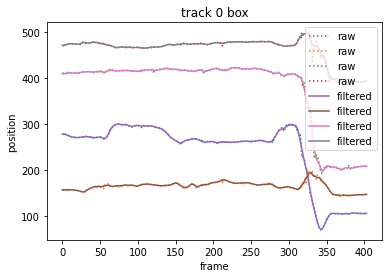

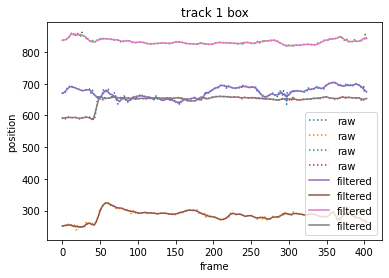

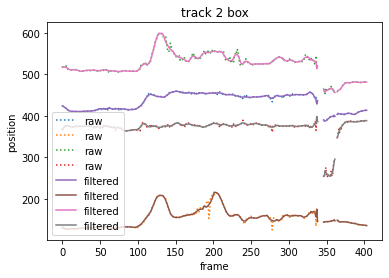

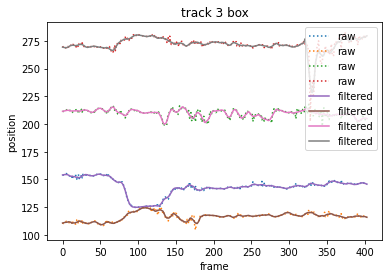

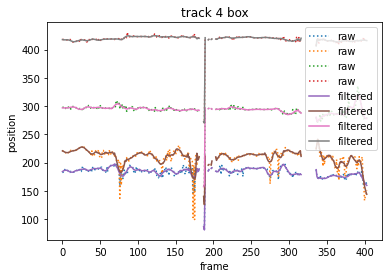

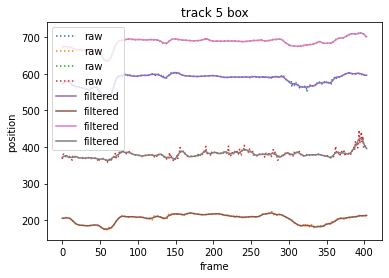

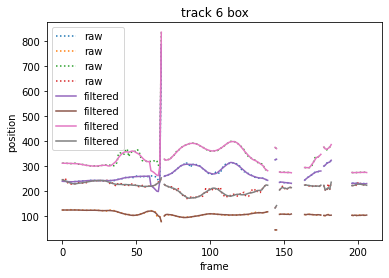

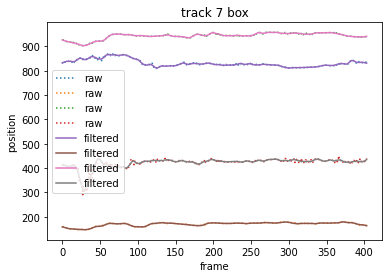

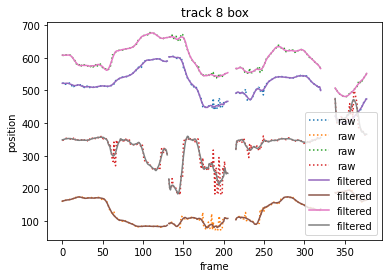

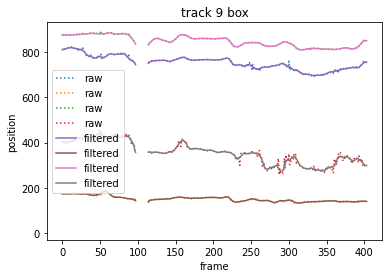

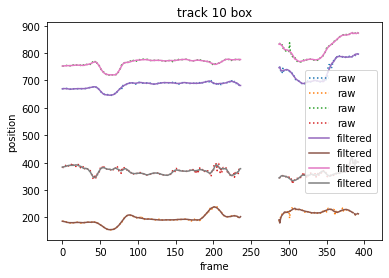

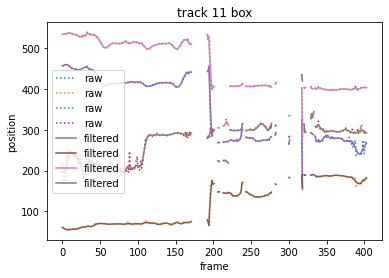

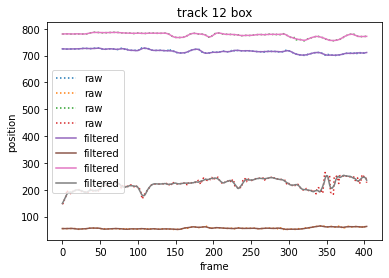

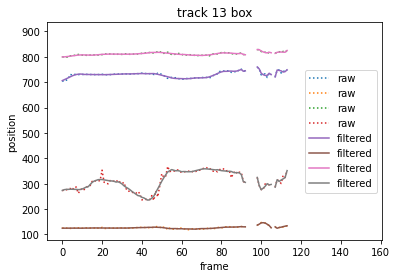

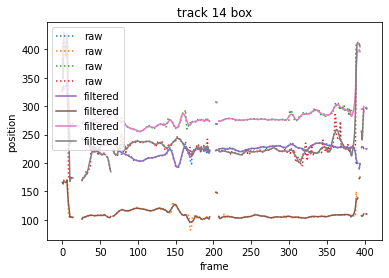

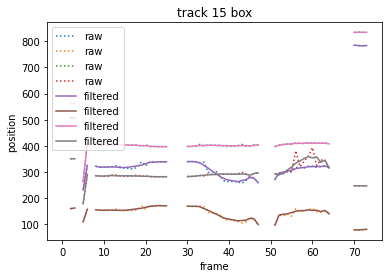

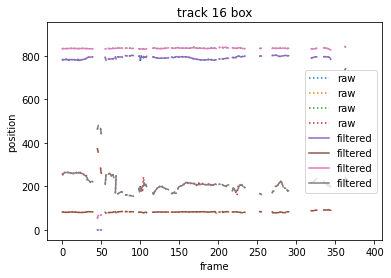

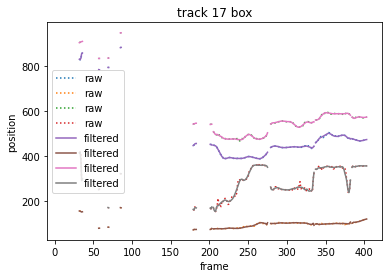

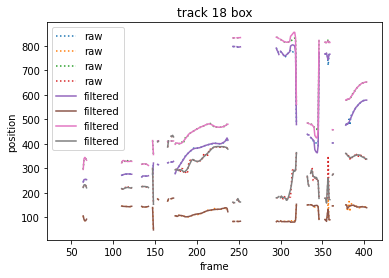

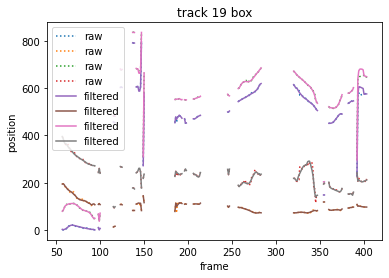

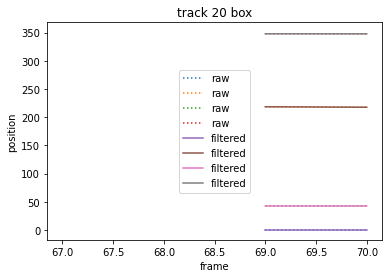

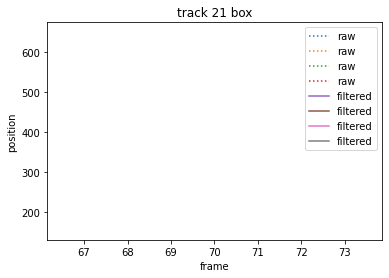

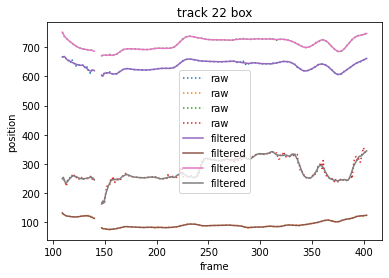

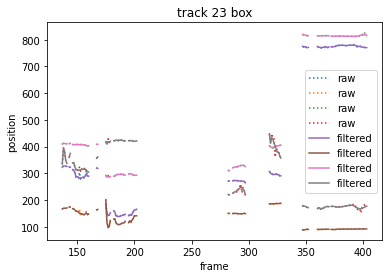

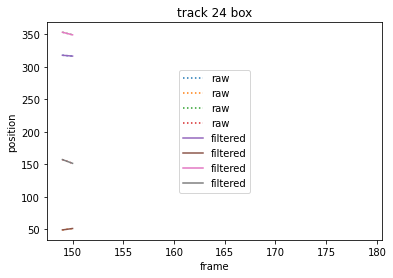

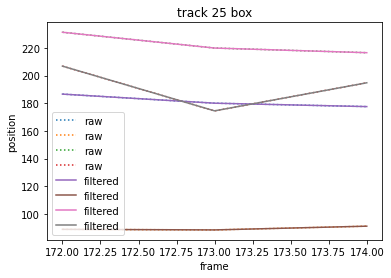

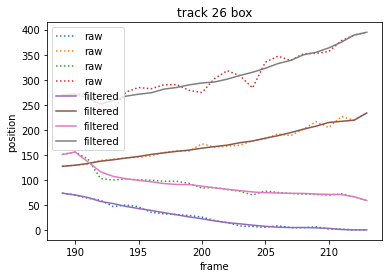

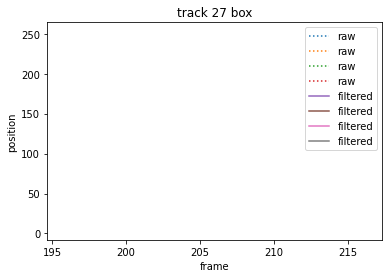

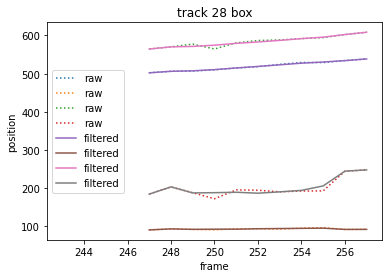

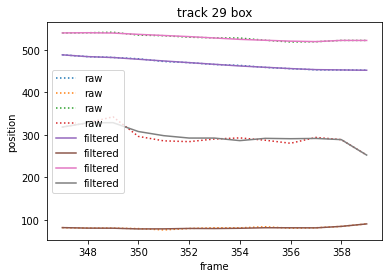

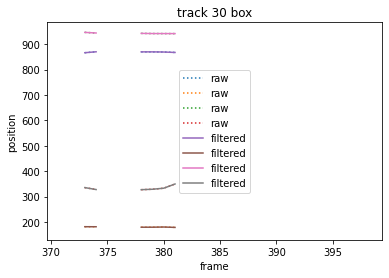

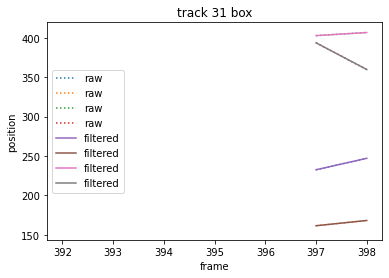

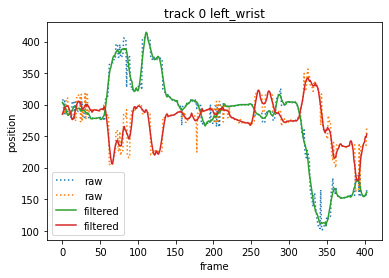

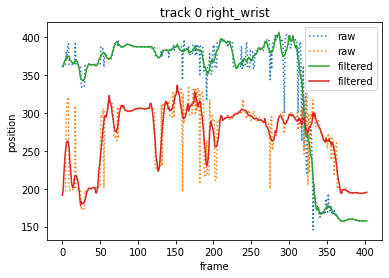

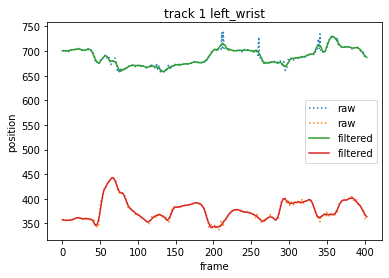

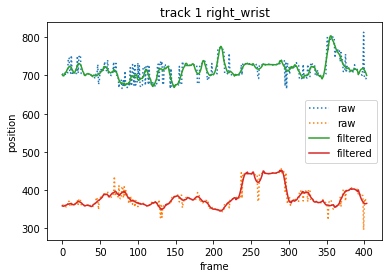

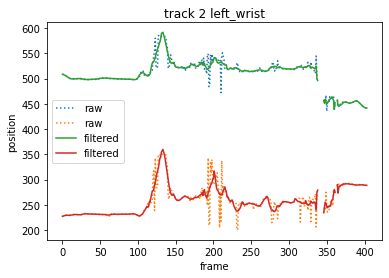

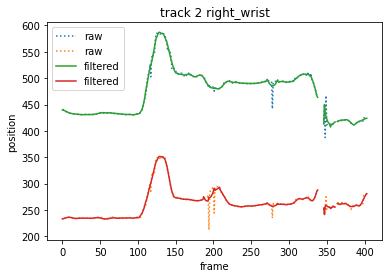

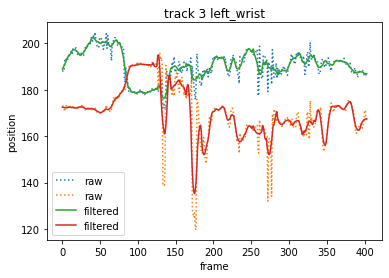

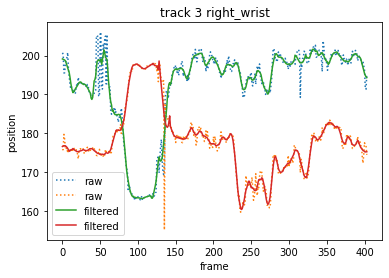

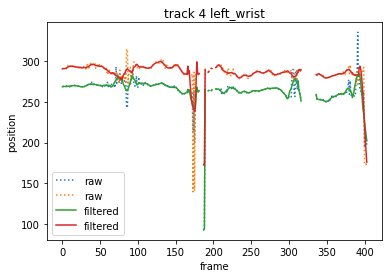

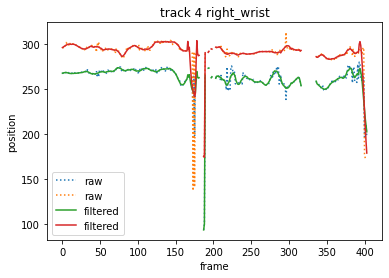

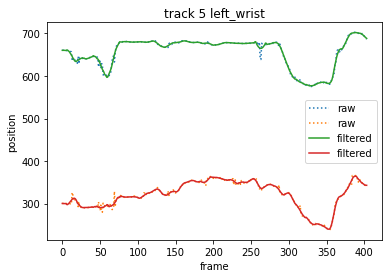

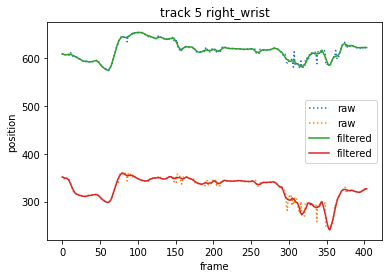

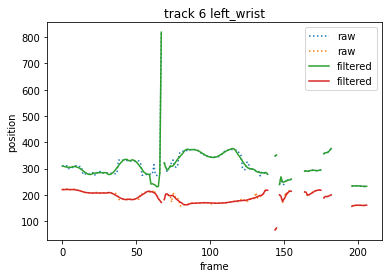

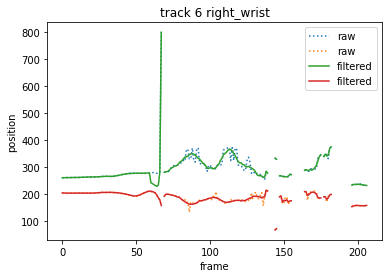

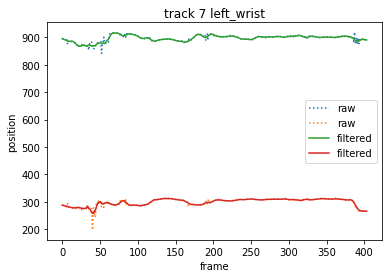

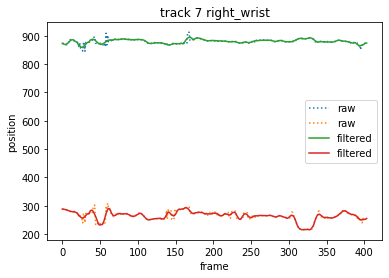

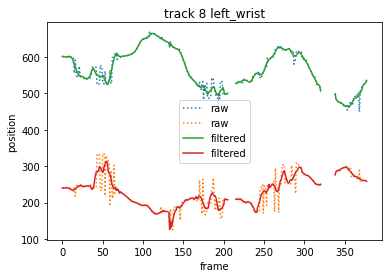

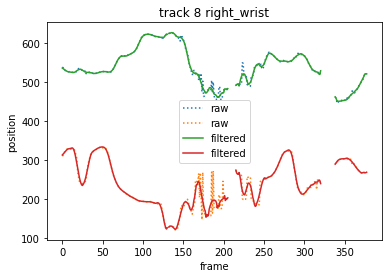

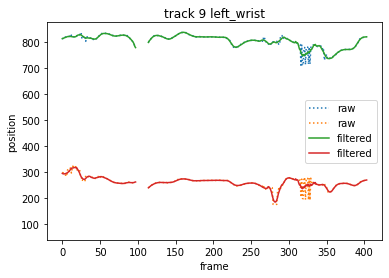

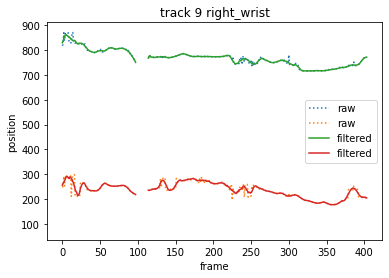

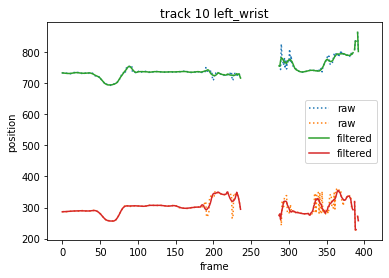

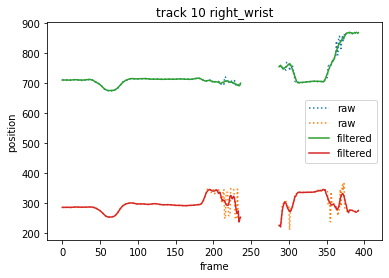

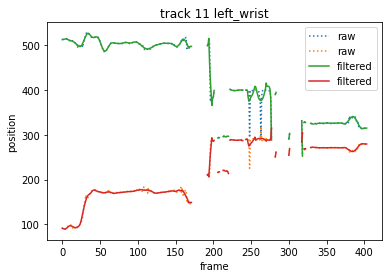

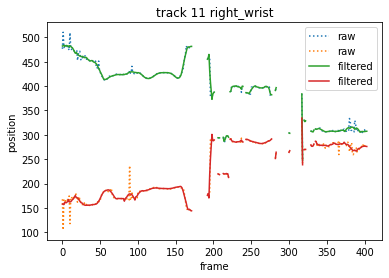

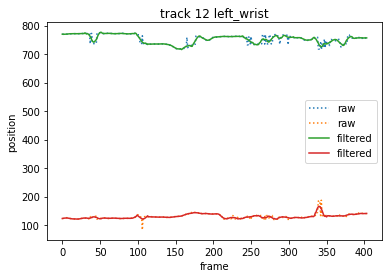

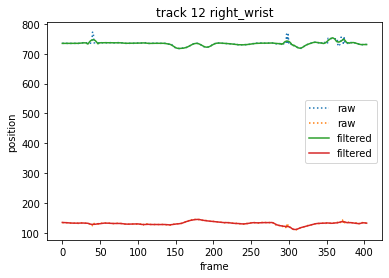

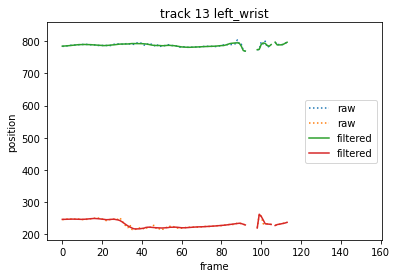

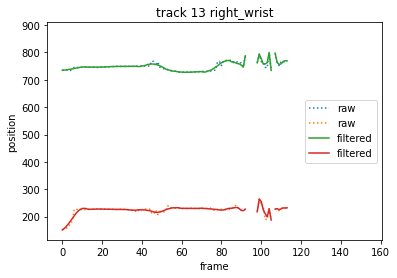

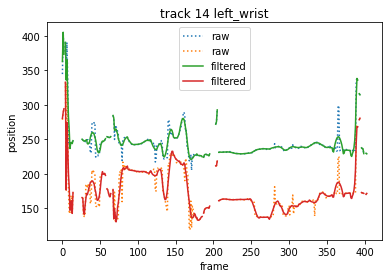

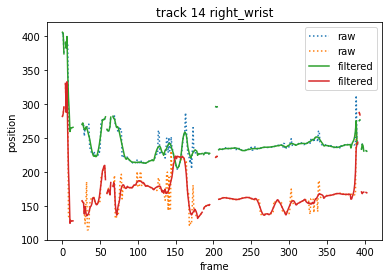

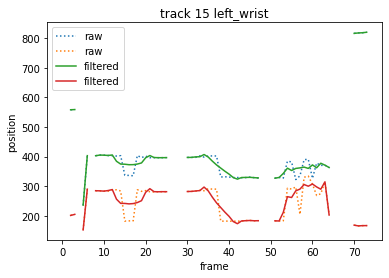

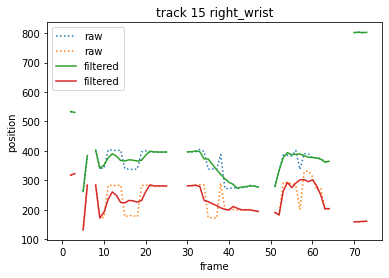

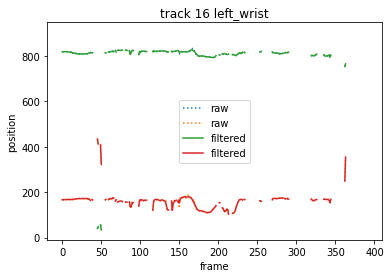

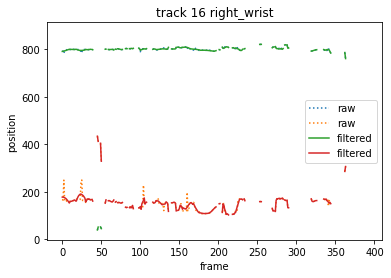

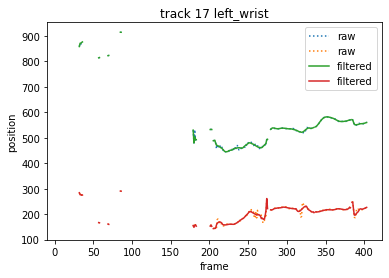

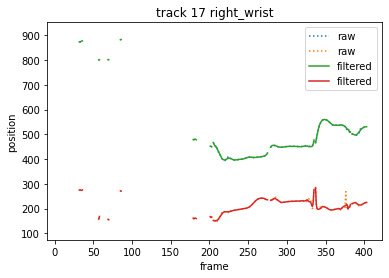

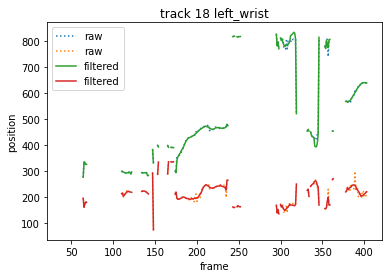

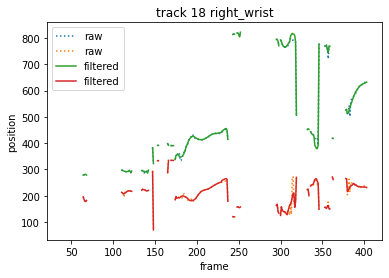

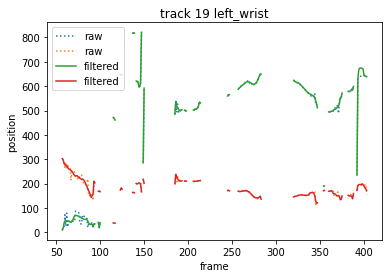

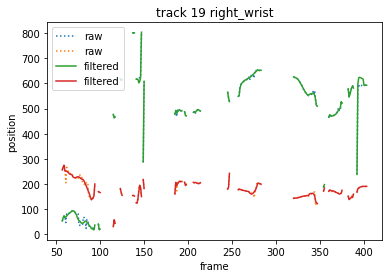

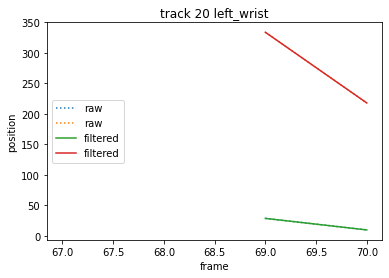

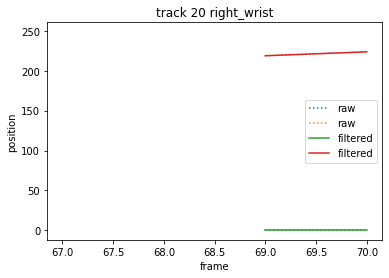

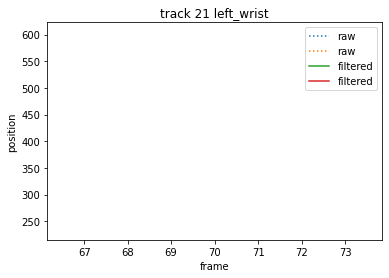

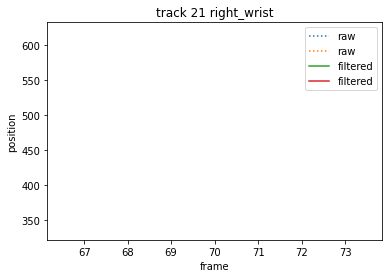

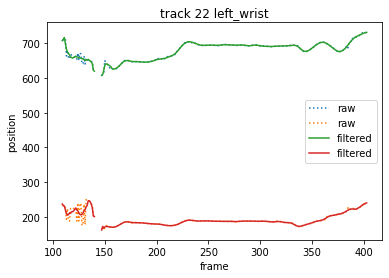

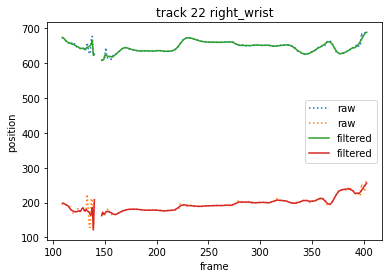

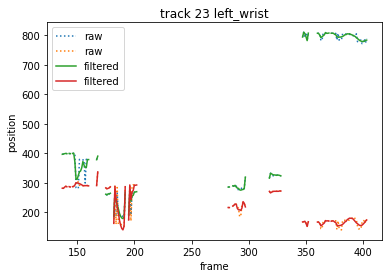

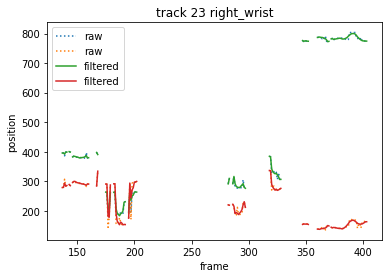

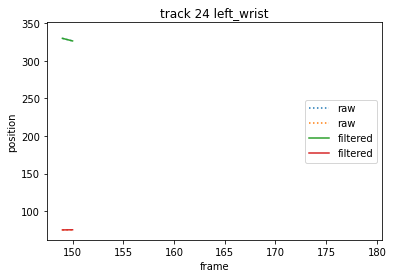

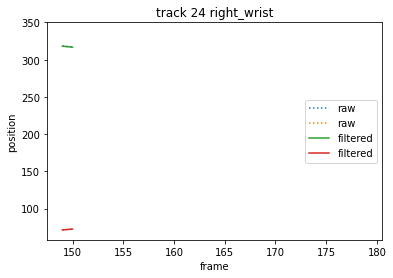

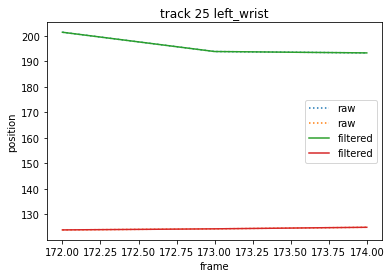

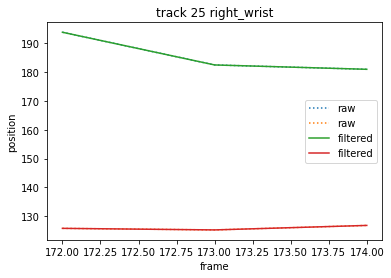

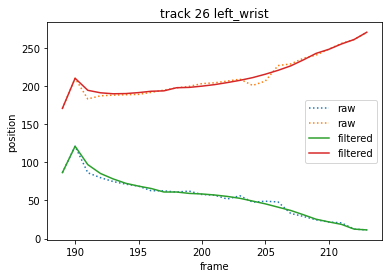

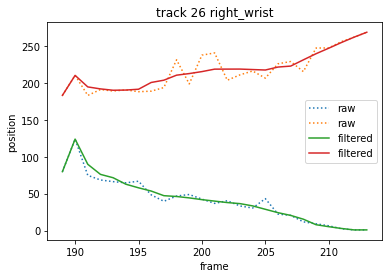

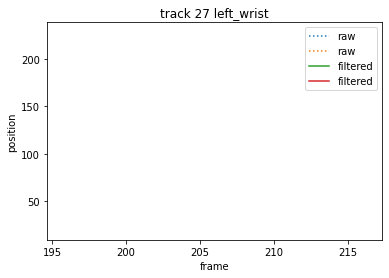

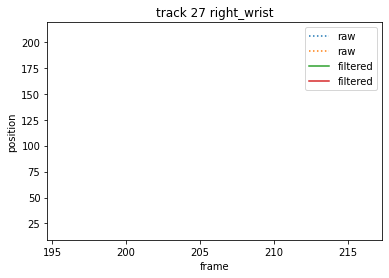

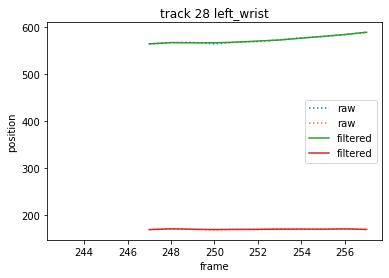

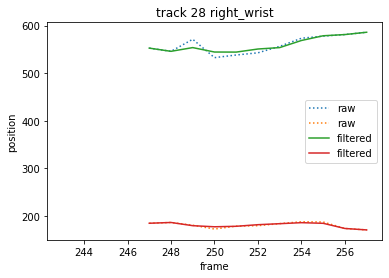

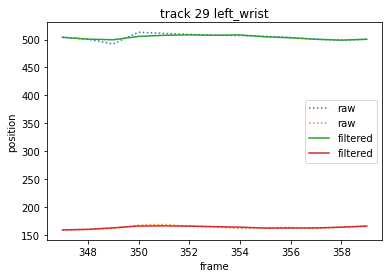

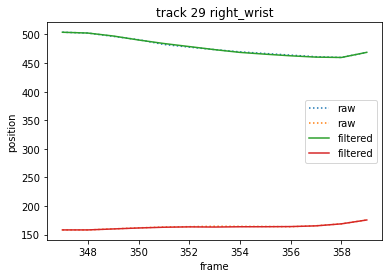

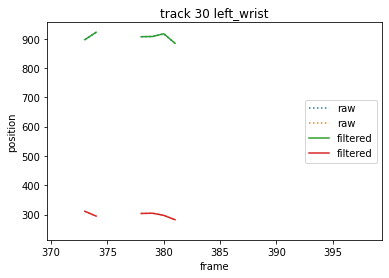

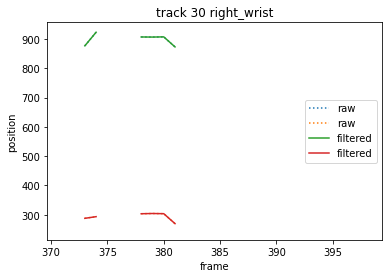

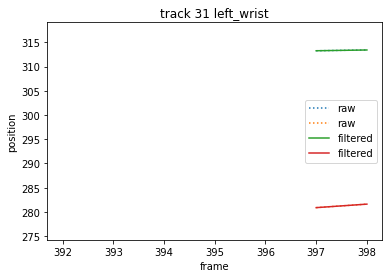

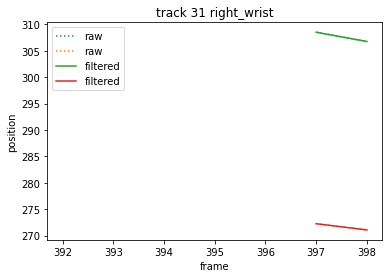

In [8]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

DO_SAVGOL_FILTER = True
FILTER_WINDOW_LENGTH = 15
FILTER_POLY_ORDER = 2


num_tracks = 1 + max(max(frame_tracks) for frame_tracks in video_tracks)
print('num_tracks:', num_tracks)
target_joint_names = [
  'left_wrist',
  'right_wrist'
]
num_joints = len(target_joint_names)
print('num_joints:', num_joints)

# for plotting
vis_kp_positions_by_joint_track = {}

# for tracking
kp_positions_by_joint_track = {}
boxes_by_track = {}
for predictions, frame_tracks in zip(all_predictions, video_tracks):
  instances = predictions['instances'].to(cpu_device)
  keypoints = np.asarray(instances.pred_keypoints)
  boxes = np.asarray(instances.pred_boxes.tensor)
  for keypoints_per_instance, box, track in zip(keypoints, boxes, frame_tracks):
    for i_joint, joint_name in enumerate(target_joint_names):
      joint_idx = JOINT_NAMES.index(joint_name)
      joint_vals = keypoints_per_instance[joint_idx]
      joint_track = track * num_joints + i_joint
      x, y, prob = joint_vals
      kp_positions_by_joint_track.setdefault(joint_track, [])
      kp_positions_by_joint_track[joint_track].append((x, y))
    
    # for plotting only
    for joint_idx, joint_name in enumerate(JOINT_NAMES):
      # values in here don't necessarily correspond to similarly named values
      # elsewhere
      joint_vals = keypoints_per_instance[joint_idx]
      _joint_track = track * len(JOINT_NAMES) + joint_idx
      x, y, prob = joint_vals
      vis_kp_positions_by_joint_track.setdefault(_joint_track, [])
      vis_kp_positions_by_joint_track[_joint_track].append((x, y))

    boxes_by_track.setdefault(track, [])
    boxes_by_track[track].append(box)

  # fill in with nans for missing tracks
  all_tracks = set(range(num_tracks))
  missing_tracks = all_tracks - set(frame_tracks)
  #print('all_tracks:', all_tracks)
  #print('frame_tracks:', frame_tracks)
  #print('missing_tracks:', missing_tracks)
  for missing_track in missing_tracks:
    for i_joint, joint_name in enumerate(target_joint_names):
      joint_track = missing_track * num_joints + i_joint
      #print('joint_track:', joint_track)
      kp_positions_by_joint_track.setdefault(joint_track, [])
      kp_positions_by_joint_track[joint_track].append((np.nan, np.nan))
    for i_joint in range(len(JOINT_NAMES)):
      _joint_track = missing_track * len(JOINT_NAMES) + i_joint
      #print('_joint_track:', _joint_track)
      vis_kp_positions_by_joint_track.setdefault(_joint_track, [])
      vis_kp_positions_by_joint_track[_joint_track].append((np.nan, np.nan))
    #print('missing_track:', missing_track)
    boxes_by_track.setdefault(missing_track, [])
    boxes_by_track[missing_track].append([np.nan for _ in range(4)])

  # all tracks should now be of the same length
  for d in (kp_positions_by_joint_track, vis_kp_positions_by_joint_track, boxes_by_track):
    lengths = [len(positions) for positions in d.values()]
    #print('lengths:', len(lengths), lengths)
    assert np.all(np.array(lengths) == lengths[0]), lengths

def smooth_savgol(values):
  filtered_values = np.ones(values.shape) * np.nan
  for window_length in range(3, FILTER_WINDOW_LENGTH + 1, 2):
    # use iteratively smaller filter sizes to smooth points at the start and end
    _filtered_values = savgol_filter(
        values,
        window_length,
        FILTER_POLY_ORDER,
        axis=0,
        mode='nearest'
    )
    mask = ~np.isnan(_filtered_values)
    mask_size = mask.sum()
    #print('window_length:', window_length, 'mask_size:', mask_size)
    filtered_values[mask] = _filtered_values[mask]
  # replace remaining missing values with original values
  num_nans = np.isnan(filtered_values).sum()
  #print('num_nans:', num_nans)
  nan_mask = np.isnan(filtered_values)
  filtered_values[nan_mask] = values[nan_mask]
  return filtered_values
  
filtered_boxes_by_track = {}
PLOT_BOX_FILTERING = True
for track, boxes in boxes_by_track.items():
  boxes = np.array(boxes)
  #print('boxes.shape:', boxes.shape)
  if DO_SAVGOL_FILTER:
    filtered_boxes = smooth_savgol(boxes)
  else:
    filtered_boxes = boxes
  
  # print('boxes:')
  # print(boxes)
  # print('filtered_boxes:')
  # print(filtered_boxes)
  assert len(filtered_boxes) == len(boxes), (
      len(filtered_boxes), len(boxes)
  )
  filtered_boxes_by_track[track] = filtered_boxes

  if PLOT_BOX_FILTERING:
    plt.figure()
    labels = ['x', 'y']
    plt.plot(boxes, label='raw', linestyle=':')
    plt.plot(filtered_boxes, label='filtered')
    plt.title(f'track {track} box')
    plt.xlabel('frame')
    plt.ylabel('position')
    plt.legend()
    plt.show()

# for visualization only
filtered_vis_kp_positions_by_joint_track = {}
for joint_track, vis_kp_positions in vis_kp_positions_by_joint_track.items():
  # TODO: resolve possible naming inconsistency
  track = joint_track // len(JOINT_NAMES)
  joint_idx = joint_track % len(JOINT_NAMES) 
  vis_kp_positions = np.array(vis_kp_positions)
  if DO_SAVGOL_FILTER:
    filtered_vis_kp_positions = smooth_savgol(vis_kp_positions)
  else:
    filtered_vis_kp_positions = vis_kp_positions

  assert len(filtered_vis_kp_positions) == len(vis_kp_positions), (
      len(filtered_vis_kp_positions), len(vis_kp_positions)
  )
  filtered_vis_kp_positions_by_joint_track[joint_track] = filtered_vis_kp_positions

filtered_kp_positions_by_joint_track = {}
PLOT_KP_FILTERING = True
for joint_track, kp_positions in kp_positions_by_joint_track.items():
  # TODO: resolve possible naming inconsistency
  track = joint_track // num_joints
  joint_idx = joint_track % num_joints 

  joint_name = target_joint_names[joint_idx]
  kp_positions = np.array(kp_positions)
  if DO_SAVGOL_FILTER:
    filtered_kp_positions = smooth_savgol(kp_positions)
  else:
    filtered_kp_positions = kp_positions
  assert len(filtered_kp_positions) == len(kp_positions), (
      len(filtered_kp_positions), len(kp_positions)
  )
  filtered_kp_positions_by_joint_track[joint_track] = filtered_kp_positions

  if PLOT_KP_FILTERING:
    plt.figure()
    labels = ['x', 'y']
    plt.plot(kp_positions, label='raw', linestyle=':')
    plt.plot(filtered_kp_positions, label='filtered')
    plt.title(f'track {track} {joint_name}')
    plt.xlabel('frame')
    plt.ylabel('position')
    plt.legend()
    plt.show()

## Filter Instances over Time

In [9]:
FILTER_INSTANCES_OVER_TIME = True
# at least this ratio must be missing on both sides in order to remove
REFERENCE_MIN_EMPTY_RATIO = 1
FILTER_ENDS = True

FILTER_TUPS = [
  # (a, b)
  # a: reference_radius
  # b: max_consecutive_nonempty_to_remove
  (10, 20),
  #(3, 5)
  (5, 2)
]

# TODO: restore from backup if it exists
_filtered_kp_positions_by_joint_track = filtered_kp_positions_by_joint_track

if FILTER_INSTANCES_OVER_TIME:
  for filter_tup in FILTER_TUPS:
    print('filter_tup:', filter_tup)
    reference_radius, max_consecutive_nonempty_to_remove = filter_tup
    # for visualization
    #for joint_track, filtered_vis_kp_positions in filtered_vis_kp_positions_by_joint_track.items():
    #for track, filtered_boxes in filtered_boxes_by_track.items():

    # for tracking
    for joint_track, filtered_kp_positions in filtered_kp_positions_by_joint_track.items():
      N = len(filtered_kp_positions)
      #print('N:', N)
      for i in range(N):
        # print('*' * 40)
        # print('i:', i)
        start_ref_start_idx = max(0, i - reference_radius)
        start_ref_end_idx = i - 1
        mid_start_idx = i
        mid_end_idx = i + max_consecutive_nonempty_to_remove - 1
        end_ref_start_idx = mid_end_idx + 1
        end_ref_end_idx = min(end_ref_start_idx + reference_radius - 1, N - 1)

        start_ref_vals = filtered_kp_positions[start_ref_start_idx : start_ref_end_idx + 1]
        mid_vals = filtered_kp_positions[mid_start_idx : mid_end_idx + 1]
        end_ref_vals = filtered_kp_positions[end_ref_start_idx : end_ref_end_idx + 1]
        
        start_ref_mask = np.all(np.isnan(start_ref_vals), axis=1)
        mid_mask = np.all(np.isnan(mid_vals), axis=1)
        end_ref_mask = np.all(np.isnan(end_ref_vals), axis=1)

        num_mid_nonempty = (~mid_mask).sum()
        mid_nonempty_idxs = [i + j for j in np.where(~mid_mask)[0]]

        start_ref_empty_ratio = start_ref_mask.mean()
        end_ref_empty_ratio = end_ref_mask.mean()

        start_condition = start_ref_empty_ratio >= REFERENCE_MIN_EMPTY_RATIO
        end_condition = end_ref_empty_ratio >= REFERENCE_MIN_EMPTY_RATIO
        if FILTER_ENDS:
          start_condition = start_condition or np.isnan(start_ref_empty_ratio)
          end_condition = end_condition or np.isnan(end_ref_empty_ratio)
        mid_condition = num_mid_nonempty > 0

        if start_condition and mid_condition and end_condition:
          print('removing num_mid_nonempty:', num_mid_nonempty)
          print('mid_nonempty_idxs:', mid_nonempty_idxs)
          filtered_kp_positions[mid_start_idx : mid_end_idx + 1] = np.nan

filter_tup: (10, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.


removing num_mid_nonempty: 1
mid_nonempty_idxs: [403]
removing num_mid_nonempty: 1
mid_nonempty_idxs: [403]
removing num_mid_nonempty: 2
mid_nonempty_idxs: [150, 153]
removing num_mid_nonempty: 2
mid_nonempty_idxs: [150, 153]
removing num_mid_nonempty: 3
mid_nonempty_idxs: [103, 106, 115]
removing num_mid_nonempty: 1
mid_nonempty_idxs: [143]
removing num_mid_nonempty: 3
mid_nonempty_idxs: [103, 106, 115]
removing num_mid_nonempty: 1
mid_nonempty_idxs: [143]
removing num_mid_nonempty: 2
mid_nonempty_idxs: [39, 41]
removing num_mid_nonempty: 7
mid_nonempty_idxs: [52, 58, 64, 65, 66, 67, 68]
removing num_mid_nonempty: 1
mid_nonempty_idxs: [88]
removing num_mid_nonempty: 14
mid_nonempty_idxs: [108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
removing num_mid_nonempty: 2
mid_nonempty_idxs: [39, 41]
removing num_mid_nonempty: 7
mid_nonempty_idxs: [52, 58, 64, 65, 66, 67, 68]
removing num_mid_nonempty: 1
mid_nonempty_idxs: [88]
removing num_mid_nonempty: 14
mid_nonempty_i

## Detect Hits

In [10]:
# TODO: estimate this
DISTANCE_THRESHOLD = 25 #20
MIN_CONSECUTIVE_HIT_FRAMES = 2


# XXX TODO: try using filtered keypoints on boxes only
USE_FILTERED_KEYPOINTS = DO_SAVGOL_FILTER and False


PLOT_FILTERED_KEYPOINTS = DO_SAVGOL_FILTER and True

print('DISTANCE_THRESHOLD:', DISTANCE_THRESHOLD)
print('MIN_CONSECUTIVE_HIT_FRAMES:', MIN_CONSECUTIVE_HIT_FRAMES)

print(len(all_predictions), 'frames')
infected_tracks = set(
  #[np.random.randint(0, max_num_instances)]
  [start_infected_track]
)
start_time = time.time()
print('len(all_keypoints):', len(all_keypoints))
print('len(video_tracks):', len(video_tracks))
assert(len(all_keypoints) == len(video_tracks))
dim = num_tracks * num_joints
consecutive_hits = np.zeros((dim, dim))
mean_keypoint_deltas = []
mean_box_deltas = []
# TODO: refactor frame_tups (dicts)
frame_tups = []
print('Tracking infections...')
for frame_id, (keypoints, frame_tracks) in enumerate(
    tqdm(zip(all_keypoints, video_tracks), total=len(all_keypoints))
):
  #print('*' * 40)
  #print('frame_id:', frame_id)
  #print('infected_tracks:', infected_tracks)
  #print('frame_tracks:', frame_tracks)
  assert len(np.unique(frame_tracks)) == len(frame_tracks), (
      len(np.unique(frame_tracks)), len(frame_tracks)
  )

  target_joint_vals = []
  target_joint_probs = []

  for instance_idx, keypoints_per_instance in enumerate(keypoints):
    # https://github.com/facebookresearch/detectron2/blob/master/detectron2/utils/visualizer.py#L703
    # a tensor of shape (K, 3), where K is the number of keypoints
    # and the last dimension corresponds to (x, y, probability).

    for i_joint, joint_name in enumerate(target_joint_names):
      joint = JOINT_NAMES.index(joint_name)        
      joint_vals = keypoints_per_instance[joint]
      x, y, prob = joint_vals

      if USE_FILTERED_KEYPOINTS:
        track = frame_tracks[instance_idx]
        joint_track = track * num_joints + i_joint
        # TODO: resolve naming inconsistency: joint_vals <> kp_positions
        try:
          filtered_joint_vals = (
              filtered_kp_positions_by_joint_track[joint_track][frame_id]
          )
        except Exception as exc:
          # TODO: remove if no longer occuring, or understand why if it is
          print(exc)
          filtered_joint_vals = (
              filtered_kp_positions_by_joint_track[joint_track][-1]
          )
        #print('before x, y:', x, y)
        x, y = filtered_joint_vals 
        #print('after x, y:', x, y)

      # TODO: use confidence?
      #confident = prob >= _KEYPOINT_THRESHOLD

      if 0:
        print(
          'joint_name:', joint_name,
          'joint_vals:', joint_vals,
          'prob:', prob
        )
      target_joint_vals.append([x, y])
      target_joint_probs.append(prob)

  target_joint_vals = np.array(target_joint_vals)
  #print('target_joint_vals:', target_joint_vals.shape)

  distances = squareform(pdist(target_joint_vals))
  #print('distances.shape:', distances.shape)

  PRINT_DISTANCES = False
  if PRINT_DISTANCES:
    np.set_printoptions(
      threshold=sys.maxsize,
      formatter={'float': lambda x: "{0:0.0f}".format(x)}
    )
    print('distances:')
    print(distances)
    np.set_printoptions()
  
  hit_mask = distances < DISTANCE_THRESHOLD
  prob_mask = np.array(target_joint_probs) > KEYPOINT_THRESHOLD
  hit_mask[~prob_mask, :] = False
  hit_mask[:, ~prob_mask] = False
  #print('hit_mask.shape:', hit_mask.shape)
  frame_infected_tracks = set()
  #frame_tracks = np.array(frame_tracks)
  hit_count_by_joint_track_tup = {}
  joint_idx_by_joint_track = {}
  for infected_track in infected_tracks:
    #print('-' * 20)
    #print('infected_track:', infected_track)
    infected_idx = np.where(frame_tracks == infected_track)[0]
    if not infected_idx.size:
      #print('track', infected_track, 'no longer in frame')
      continue
    infected_idx = infected_idx[0]
    #print('infected_idx:', infected_idx)
    
    for i_joint in range(len(target_joint_names)):
      #print('. ' * 20)
      #print('i_joint:', i_joint)
      infected_joint_idx = infected_idx * len(target_joint_names) + i_joint
      row = hit_mask[infected_joint_idx]
      #print('row:', [1 if v else 0 for v in row ])
      #print('row.shape:', row.shape)
      hit_joint_idxs = np.where(row)[0].tolist()
      #print('hit_joint_idxs:', hit_joint_idxs)

      for hit_joint_idx in hit_joint_idxs:
        hit_track_idx = hit_joint_idx // num_joints
        hit_track = frame_tracks[hit_track_idx]

        infected_joint_track = infected_track * num_joints + i_joint
        hit_joint_track = hit_track * num_joints + i_joint

        if infected_joint_track == hit_joint_track:
          continue

        joint_idx_by_joint_track[infected_joint_track] = infected_joint_idx
        joint_idx_by_joint_track[hit_joint_track] = hit_joint_idx

        hit_count = 1 + (
            consecutive_hits[infected_joint_track][hit_joint_track]
        )
        joint_track_tup = (infected_joint_track, hit_joint_track)

        if joint_track_tup in hit_count_by_joint_track_tup:
          # This can happen if more than one of an infected person's joints
          # touch someone else's joint (e.g. double handshake).
          # Doing nothing treats this as a single hit.
          pass
        hit_count_by_joint_track_tup[joint_track_tup] = hit_count
  
  # TODO: don't fill if missing joint_idx belongs to track that's not visible
  # in this frame, or if it's within e.g. MIN_CONSECUTIVE_DEAD_KP_FRAMES frames
  # (it might reappear)
  consecutive_hits.fill(0)
  for (a_idx, b_idx), hit_count in hit_count_by_joint_track_tup.items():
    consecutive_hits[a_idx][b_idx] = hit_count
    consecutive_hits[b_idx][a_idx] = hit_count
  PRINT_CONSECUTIVE_HITS = False
  if PRINT_CONSECUTIVE_HITS:
    np.set_printoptions(
      threshold=sys.maxsize,
      formatter={'float': lambda x: "{0:0.0f}".format(x)}
    )
    print('consecutive_hits:')
    print(consecutive_hits)
    np.set_printoptions()

  hit_tracks = []
  all_hit_joint_track_tups = []
  consecutive_hit_joint_track_tups = []
  for joint_track_tup, hit_count in hit_count_by_joint_track_tup.items():
    infected_joint_track, hit_joint_track = joint_track_tup
    infected_track = infected_joint_track // num_joints
    hit_track = hit_joint_track // num_joints
    if infected_track == hit_track:
      continue

    all_hit_joint_track_tups.append(joint_track_tup)
    if hit_count < MIN_CONSECUTIVE_HIT_FRAMES:
      continue
    consecutive_hit_joint_track_tups.append(joint_track_tup)
    hit_track = hit_joint_track // num_joints
    hit_tracks.append(hit_track)

  #print('hit_tracks:', hit_tracks)
  frame_infected_tracks |= set(hit_tracks)

  frame = frames[frame_id]
  predictions = all_predictions[frame_id]
  instances = predictions['instances'].to(cpu_device)
  cur_boxes = np.asarray(instances.pred_boxes.tensor)

  if USE_FILTERED_KEYPOINTS or PLOT_FILTERED_KEYPOINTS:

    # TODO: rename
    pred_boxes = cur_boxes.copy()
    #print('pred_boxes:')
    #print(pred_boxes)
    num_instances = pred_boxes.shape[0]
    assert pred_boxes.shape == (num_instances, 4), (pred_boxes.shape, (num_instances, 4))
    pred_keypoints = instances.pred_keypoints.numpy().copy()
    #print('pred_keypoints:')
    #print(pred_keypoints)
    assert pred_keypoints.shape == (num_instances, len(JOINT_NAMES), 3), (
        pred_keypoints.shape, (num_instances, len(JOINT_NAMES), 3)
    )
    box_deltas = []
    keypoint_deltas = []
    for instance_idx in range(num_instances):
      track = frame_tracks[instance_idx]
      filtered_boxes = filtered_boxes_by_track[track]

      track_box = filtered_boxes[frame_id]

      #print('before:', pred_boxes[instance_idx, :])
      box_delta = pred_boxes[instance_idx, :] - track_box
      box_deltas.append(box_delta)
      pred_boxes[instance_idx, :] = track_box
      #print('after:', pred_boxes[instance_idx, :])

      # filtered_vis_kp_positions_by_joint_track
      for i_joint in range(len(JOINT_NAMES)):
        joint_track = track * len(JOINT_NAMES) + i_joint
        filtered_vis_kp_positions = filtered_vis_kp_positions_by_joint_track[joint_track]
        track_positions = filtered_vis_kp_positions[frame_id]
        
        #print('before:', pred_keypoints[instance_idx][i_joint])
        keypoint_delta = pred_keypoints[instance_idx][i_joint][:2] - track_positions
        keypoint_deltas.append(keypoint_delta)
        pred_keypoints[instance_idx][i_joint][:2] = track_positions
        #print('after:', pred_keypoints[instance_idx][i_joint])

    mean_box_delta = np.abs(np.array(box_deltas)).mean()
    #print('mean_box_delta:', mean_box_delta)
    assert DO_SAVGOL_FILTER == bool(mean_box_delta), mean_box_delta
    mean_box_deltas.append(mean_box_delta)
    
    mean_keypoint_delta = np.abs(np.array(keypoint_deltas)).mean()
    #print('mean_keypoint_delta:', mean_keypoint_delta)
    assert DO_SAVGOL_FILTER == bool(mean_keypoint_delta), mean_keypoint_delta
    mean_keypoint_deltas.append(mean_keypoint_delta)

    before = instances.pred_boxes.tensor.numpy()
    instances.pred_boxes.tensor = torch.from_numpy(pred_boxes)
    after = instances.pred_boxes.tensor.numpy()
    assert DO_SAVGOL_FILTER == bool((before - after).mean())

    before = instances.pred_keypoints.numpy()
    instances.set('pred_keypoints', torch.from_numpy(pred_keypoints))
    after = instances.pred_keypoints.numpy()
    assert DO_SAVGOL_FILTER == bool((before - after).mean())

    cur_boxes = pred_boxes

  frame_tups.append((
    frame, instances, cur_boxes, frame_tracks, frame_infected_tracks,
    set(infected_tracks), consecutive_hit_joint_track_tups,
    all_hit_joint_track_tups, joint_idx_by_joint_track, target_joint_vals
  ))

  infected_tracks |= frame_infected_tracks

print('final infected_tracks:', infected_tracks)
duration = time.time() - start_time
print('duration:', duration)
mean_box_delta = np.mean(mean_box_deltas)
print('mean_box_delta:', mean_box_delta)
mean_keypoint_delta = np.mean(mean_keypoint_deltas)
print('mean_keypoint_delta:', mean_keypoint_delta)

'''
filter window length 61
mean_mean_box_delta: 1.9673217390508577
mean_mean_keypoint_delta: 2.335863792205027

filter window length 121
mean_mean_box_delta: 2.1252719775349673
mean_mean_keypoint_delta: 2.6383550710672163

filter window length 251
mean_mean_box_delta: 2.552904603603061
mean_mean_keypoint_delta: 2.911478190218577
'''
pass

DISTANCE_THRESHOLD: 25
MIN_CONSECUTIVE_HIT_FRAMES: 2
404 frames
len(all_keypoints): 404
len(video_tracks): 404
Tracking infections...



final infected_tracks: {1, 5, 7, 9, 10, 17, 18, 22}
duration: 0.8635191917419434
mean_box_delta: 1.8108363546222868
mean_keypoint_delta: 2.339634997728169


## Pad Hits to get Interactions

In [11]:
PADDING_SECONDS = .5
# TODO: rename
r = 20
PADDING_FRAMES = int(PADDING_SECONDS * frames_per_second)
print('PADDING_FRAMES:', PADDING_FRAMES)
IGNORE_SUBSEQUENT_HITS = True

all_boundaries_by_joint_track_tup = [dict() for _ in range(len(frame_tups))]
all_interactions = [[] for _ in range(len(frame_tups))]
print('Computing interactions...')
for frame_idx, (
    _,#frame,
    _,#instances,
    _,#cur_boxes,
    _,#frame_tracks,
    _,#frame_infected_tracks,
    _,#infected_tracks,
    consecutive_hit_joint_track_tups,
    all_hit_joint_track_tups,
    joint_idx_by_joint_track,
    target_joint_vals
) in tqdm(enumerate(frame_tups), total=len(frame_tups)):

  past_frame_idx = max(frame_idx - PADDING_FRAMES, 0)
  future_frame_idx = min(frame_idx + PADDING_FRAMES, len(frame_tups) - 1)
  if consecutive_hit_joint_track_tups:
    #print('Padding hits at frame_idx:', frame_idx)
    # TODO: do this more efficiently
    for tup in consecutive_hit_joint_track_tups:
      tup = tuple(sorted(tup))
      #print('tup:', tup)
      for _frame_idx in range(past_frame_idx, future_frame_idx + 1):
        #print('_frame_idx:', _frame_idx, 'tup:', tup)

        infected_joint_track, hit_joint_track = tup
        infected_joint_idx = joint_idx_by_joint_track[infected_joint_track]
        hit_joint_idx = joint_idx_by_joint_track[hit_joint_track]

        infected_joint_vals = target_joint_vals[infected_joint_idx]
        hit_joint_vals = target_joint_vals[hit_joint_idx]
        xA, yA = infected_joint_vals
        xB, yB = hit_joint_vals
        cA = int(min(xA, xB)) - r
        cB = int(max(xA, xB)) + r
        rA = int(min(yA, yB)) - r
        rB = int(max(yA, yB)) + r

        # more than one pair of joints hits between the same pair of tracks
        all_boundaries_by_joint_track_tup[_frame_idx].setdefault(tup, [])
        all_boundaries_by_joint_track_tup[_frame_idx][tup].append((rA, rB, cA, cB))

all_highlight_track_tups = [set() for _ in range(len(frame_tups))]
all_boundary_by_track_tup = [{} for _ in range(len(frame_tups))]
max_boundary_by_track_tup = {}
active_track_tups = set()

# replace consecutive boundaries with largest extent
for frame_idx, boundaries_by_joint_track_tup in enumerate(all_boundaries_by_joint_track_tup):
  #print('*' * 40)
  #print('frame_idx:', frame_idx)
  
  # convert joint tracks into tracks
  boundaries_by_track_tup = {}
  for joint_track_tup, boundaries in boundaries_by_joint_track_tup.items():
    track_tup = tuple([val // num_joints for val in joint_track_tup])
    boundaries_by_track_tup.setdefault(track_tup, set())
    boundaries_by_track_tup[track_tup] |= set(boundaries)
  #print('boundaries_by_track_tup:', boundaries_by_track_tup)

  for track_tup, boundaries in boundaries_by_track_tup.items():

    # update max boundary
    #active_track_tups.add(track_tup)
    if track_tup in max_boundary_by_track_tup:
      max_boundary = max_boundary_by_track_tup[track_tup]
    else:
      max_boundary = (0, 0, 0, 0)
    for boundary in boundaries:
      rA, rB, cA, cB = boundary
      _rA, _rB, _cA, _cB = max_boundary
      max_boundary = (
        min(rA, _rA) or rA,
        max(rB, _rB),
        min(cA, _cA) or cA,
        max(cB, _cB)
      )
      max_boundary_by_track_tup[track_tup] = max_boundary

    max_boundary = max_boundary_by_track_tup[track_tup]
    #print('max_boundary:', max_boundary)
    all_boundary_by_track_tup[frame_idx][track_tup] = max_boundary

    # add current tup to active tups 
    # only add a track tup if both tracks were not previously infected
    if frame_idx > 0 and IGNORE_SUBSEQUENT_HITS:
      prev_infected_tracks = frame_tups[frame_idx - 1][5]
      #print('prev_infected_tracks:', prev_infected_tracks)
      if any(track not in prev_infected_tracks for track in track_tup):
        active_track_tups.add(track_tup)
    else:
      active_track_tups.add(track_tup)

  # if a tup is no longer visible, or video has ended,
  # go back and fill it in with the largest extent
  #print('active_track_tups:', active_track_tups)
  for active_track_tup in list(active_track_tups):
    if active_track_tup not in boundaries_by_track_tup or frame_idx == len(frame_tups) - 1:
      # no longer visible, so go back and fill in
      max_boundary = max_boundary_by_track_tup[active_track_tup]
      print('backfilling active_track_tup:', active_track_tup, 'with max_boundary', max_boundary)
      _frame_idx = frame_idx - 1
      interaction = {
          'idxs': None,
          'tracks': active_track_tup
      }
      while _frame_idx >= 0 and active_track_tup in all_boundary_by_track_tup[_frame_idx]:
        #print('backfilling _frame_idx:', _frame_idx)
        _boundary_by_track_tup = all_boundary_by_track_tup[_frame_idx]
        _boundary_by_track_tup[active_track_tup] = max_boundary
        _frame_idx -= 1
        # record interaction
        all_interactions[_frame_idx].append(interaction)

      # update interaction
      interaction_start_idx = _frame_idx + 1
      interaction_end_idx = frame_idx - 1
      interaction_mid_idx = (interaction_start_idx + interaction_end_idx) / 2
      interaction['idxs'] = (
        interaction_start_idx,
        interaction_mid_idx,
        interaction_end_idx
      )

      active_track_tups.remove(active_track_tup)
      #print('max_boundary_by_track_tup:', max_boundary_by_track_tup)
      #print('active_track_tup:', active_track_tup)
      del max_boundary_by_track_tup[active_track_tup]

  all_highlight_track_tups[frame_idx] |= active_track_tups

print('Done.')
# print('all_highlight_track_tups:')
# pprint(all_highlight_track_tups)
# print('all_boundary_by_track_tup:')
# pprint(all_boundary_by_track_tup)

PADDING_FRAMES: 7
Computing interactions...



backfilling active_track_tup: (1, 5) with max_boundary (322, 388, 621, 691)
backfilling active_track_tup: (1, 10) with max_boundary (312, 374, 665, 729)
backfilling active_track_tup: (9, 10) with max_boundary (204, 245, 734, 774)
backfilling active_track_tup: (9, 22) with max_boundary (155, 209, 673, 737)
backfilling active_track_tup: (5, 17) with max_boundary (197, 260, 560, 603)
backfilling active_track_tup: (17, 18) with max_boundary (186, 268, 487, 591)
backfilling active_track_tup: (7, 10) with max_boundary (246, 297, 848, 891)
Done.


## Visualize interactions and infections

inf_output_fname: salsa_cpp_cam4.avi-reenc.avi-inf.mp4
Visualizing...


new_infected_tracks: {5}
new_infected_tracks: {10}
new_infected_tracks: {9}
frame_id: 288 hits: [(21, 19)] interactions: [{'idxs': (281, 288.0, 295), 'tracks': (9, 10)}]


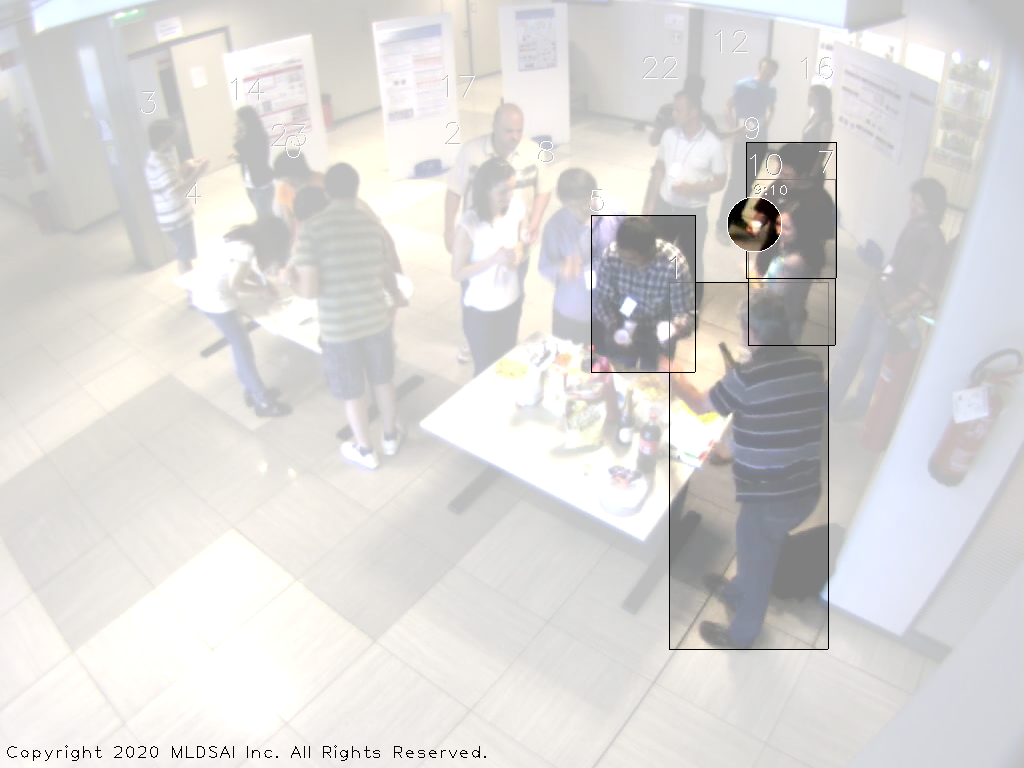

new_infected_tracks: {22}
frame_id: 332 hits: [(44, 18), (19, 45)] interactions: [{'idxs': (323, 332.0, 341), 'tracks': (9, 22)}]


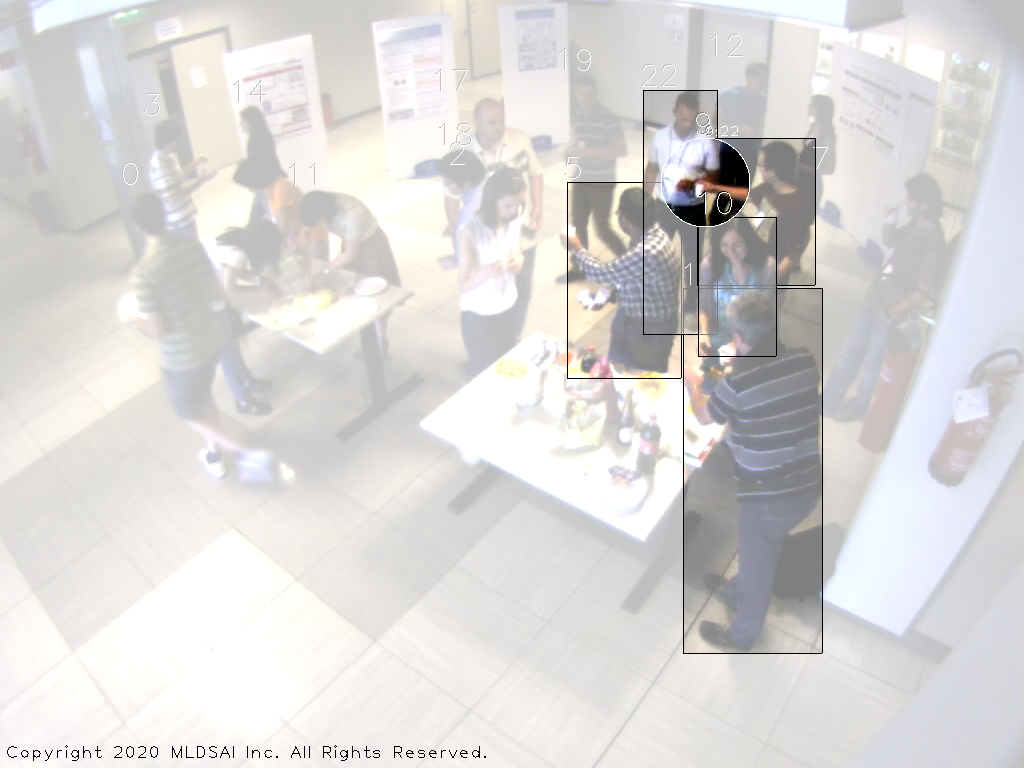

new_infected_tracks: {17}
frame_id: 354 hits: [(34, 10), (10, 34)] interactions: [{'idxs': (346, 354.0, 362), 'tracks': (5, 17)}]


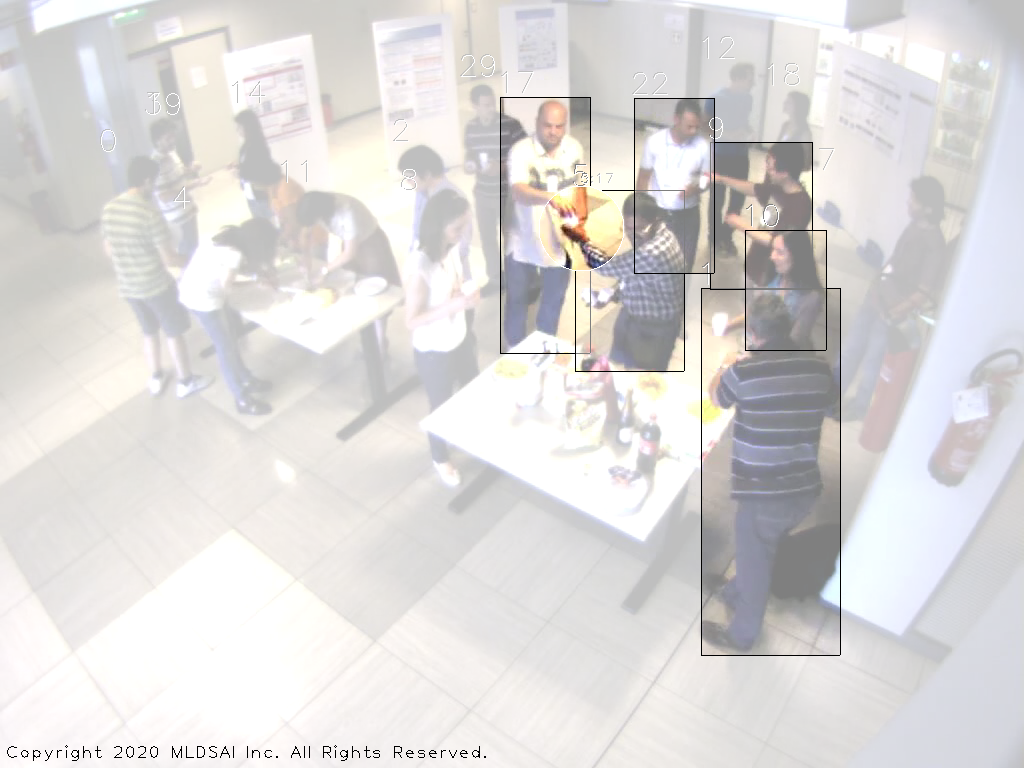

new_infected_tracks: {18}
new_infected_tracks: {7}
frame_id: 382 hits: [(34, 36), (36, 34)] interactions: [{'idxs': (372, 382.0, 392), 'tracks': (17, 18)}, {'idxs': (373, 384.5, 396), 'tracks': (7, 10)}]


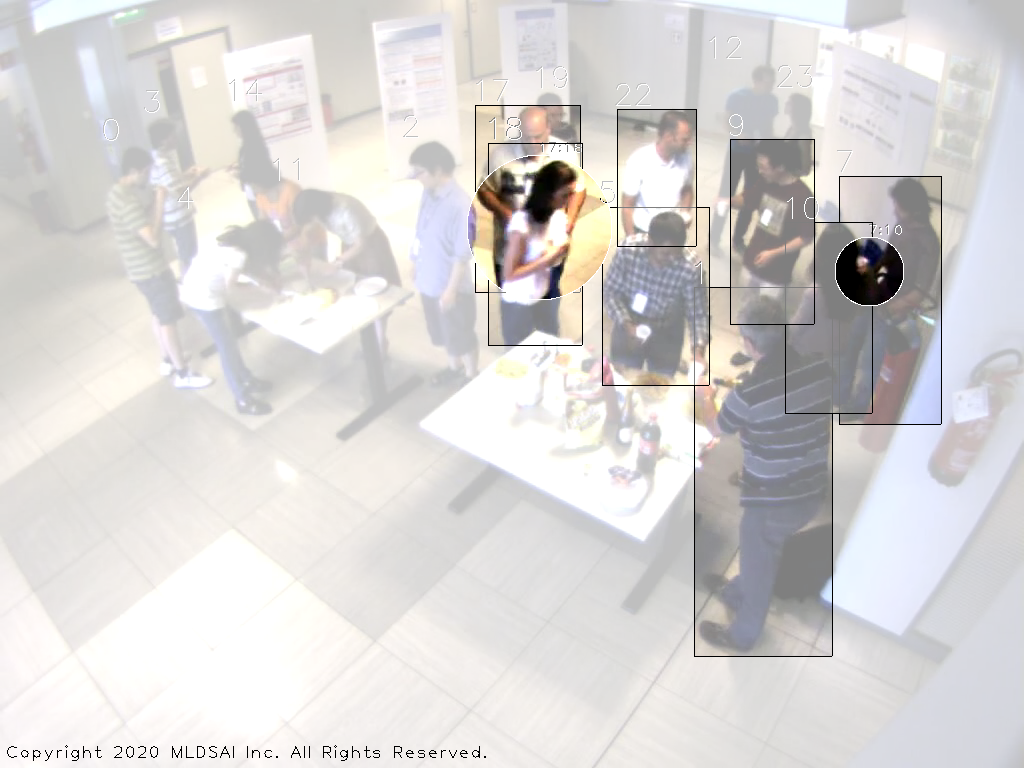


duration: 49.470245122909546
wrote 4455444 bytes to salsa_cpp_cam4.avi-reenc.avi-inf.mp4
-rw-r--r-- 1 root root 4.3M May 12 02:29 salsa_cpp_cam4.avi-reenc.avi-inf.mp4


In [12]:
WRITE_INF_OUTPUT = True
APPEND_JOINT_TRACKS_TO_LABEL = False
HIGHLIGHT_HITS = False
HIGHLIGHT_INTERACTIONS = True
HIDE_KEYPOINTS = True
HIDE_BOXES = True
PREVIEW_HITS = False
PREVIEW_INTERACTIONS = True

inf_output_fname = f'{video_filename_reenc}-inf.mp4'
print('inf_output_fname:', inf_output_fname)
inf_output_file = cv2.VideoWriter(
    filename=inf_output_fname,
    fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
    fps=float(frames_per_second),
    frameSize=(width, height),
    isColor=True,
)

start_time = time.time()
print('Visualizing...')
for frame_id, ((
    frame,
    instances,
    cur_boxes,
    frame_tracks,
    frame_infected_tracks,
    infected_tracks,
    consecutive_hit_joint_track_tups,
    all_hit_joint_track_tups,
    joint_idx_by_joint_track,
    target_joint_vals
), highlight_track_tups, boundary_by_track_tup) in tqdm(
    enumerate(zip(frame_tups, all_highlight_track_tups, all_boundary_by_track_tup)), total=len(frame_tups)
):
  #print('*' * 40)
  #print('frame_id:', frame_id)

  vis_frame = visualize_predictions(frame, instances, hide_keypoints=HIDE_KEYPOINTS, hide_boxes=HIDE_BOXES)
  for box, frame_track in zip(cur_boxes, frame_tracks):
    cv2.putText(vis_frame, str(frame_track), (int(box[0]-5), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))
    cv2.putText(vis_frame, str(frame_track), (int(box[0]-4), int(box[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255))

  b_channel, g_channel, r_channel = cv2.split(vis_frame)
  alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 64

  interaction_mask_inner = np.zeros(b_channel.shape, dtype=np.bool)
  interaction_mask_outer = np.zeros(b_channel.shape, dtype=np.bool)
  if HIGHLIGHT_INTERACTIONS:
    #print('highlight_track_tups:', highlight_track_tups)
    #print('boundary_by_track_tup:', boundary_by_track_tup)
    for highlight_track_tup in highlight_track_tups:
      boundary = boundary_by_track_tup[highlight_track_tup]
      tup = sorted(highlight_track_tup)
      label = f'{tup[0]}:{tup[1]}'
      inner, outer = draw_circular_boundary(boundary, label)
      interaction_mask_inner |= inner
      interaction_mask_outer |= outer

  # highlight infected
  #print('frame_infected_tracks:', frame_infected_tracks)
  #print('infected_tracks:', infected_tracks)
  highlight_tracks = frame_infected_tracks | infected_tracks
  #print('highlight_tracks:', highlight_tracks)
  highlight_boxes = []
  # sort by area to plot smallest boxes last
  areas = []
  track_ids = []
  for track in highlight_tracks:
    track_id = np.where(frame_tracks == track)[0]
    if not track_id.size:
      # track is not visible in this frame
      continue
    track_id = track_id[0]
    track_ids.append(track_id)
    box = cur_boxes[track_id]
    xA = box[0]
    yA = box[1]
    xB = box[2]
    yB = box[3]
    height = abs(yB - yA)
    width = abs(xB - xA)
    area = height * width
    areas.append(area)
  # largest to smallest
  sorted_idxs = np.argsort(areas)[::-1]
  #print('sorted_idxs:', sorted_idxs)
  #print('*' * 40)
  for sorted_idx in sorted_idxs:
    #area = areas[sorted_idx]
    #print('area:', area)
    track_id = track_ids[sorted_idx]
    box = cur_boxes[track_id]
    highlight_boxes.append(box)

  '''
  for track in highlight_tracks:
    track_id = np.where(frame_tracks == track)[0]
    if not track_id.size:
      # track is not visible in this frame
      continue
    track_id = track_id[0]
    #print('track_id:', track_id)
    box = cur_boxes[track_id]
    #print('box:', box)
    highlight_boxes.append(box)
  '''

  #print('highlight_boxes:', highlight_boxes)
  for box in highlight_boxes:
    #print('box:', box, 'box[0]:', box[0])
    x_max = alpha_channel.shape[1] - 1
    y_max = alpha_channel.shape[0] - 1
    xA = min(int(box[0]), x_max)
    yA = min(int(box[1]), y_max)
    xB = min(int(box[2]), x_max)
    yB = min(int(box[3]), y_max)
    try:
      alpha_channel[yA:yB, xA:xB] = 128
      alpha_channel[yA, xA:xB] = 255
      alpha_channel[yB, xA:xB] = 255
      alpha_channel[yA:yB, xA] = 255
      alpha_channel[yA:yB, xB] = 255
    except Exception as exc:
      print('exc:', exc)
      print('box:', box)
      print('xA:', xA)
      print('xB:', xB)
      print('yA:', yA)
      print('yB:', yB)
      print('alpha_channel.shape:', alpha_channel.shape)
      '''
exc: index 1042 is out of bounds for axis 1 with size 1024
box: [1042.2977   271.72623 1089.5759   433.13748]
xA: 1042
xB: 1023
yA: 271
yB: 433
alpha_channel.shape: (768, 1024)
      '''
      continue

    for channel in b_channel, g_channel, r_channel:
      channel[yA, xA:xB] = 0
      channel[yB, xA:xB] = 0
      channel[yA:yB, xA] = 0
      channel[yA:yB, xB] = 0

  def draw_boundary(boundary, _label):
    #print('draw_boundary() boundary:', boundary, '_label:', _label)
    rA, rB, cA, cB = boundary
    alpha_channel[rA:rB, cA:cB] = 255
    for channel in (b_channel, g_channel, r_channel):
      channel[rA, cA:cB] = 255
      channel[rB, cA:cB] = 255
      channel[rA:rB, cA] = 255
      channel[rA:rB, cB] = 255
      cv2.putText(channel, _label, (cA-2, rA-2), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0))
      cv2.putText(channel, _label, (cA-1, rA-1), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    
  # TODO: rename
  def draw_circular_boundary(boundary, _label=None, thickness=1):
    rA, rB, cA, cB = boundary
    height, width = b_channel.shape

    if 0:
      # for testing
      rA = 2
      rB = 8
      cA = 3
      cB = 7
      height = 10
      width = 8

    max_dim = max(cB - cA, rB - rA)
    # print('height:', height)
    # print('width:', width)
    # print('max_dim:', max_dim)
    # print('rA:', rA)
    # print('rB:', rB)
    # print('cA:', cA)
    # print('cB:', cB)
    radius = int(np.sqrt(2 * (max_dim // 2)**2))  # max_dim // 2 #
    rC = (rA + rB) // 2
    cC = (cA + cB) // 2
    xs = [i - cC for i in range(width)]
    ys = [i - rC for i in range(height)]
    # print('radius:', radius)
    # print('rC:', rC)
    # print('cC:', cC)
    # print('xs:', xs)
    # print('ys:', ys)
    xv, yv = np.meshgrid(xs, ys, sparse=False, indexing='xy')
    #print('xv:', xv)
    #print('yv:', yv)
    rv = np.sqrt(xv**2 + yv**2)
    #print('rv:', rv)
    outer_mask = rv < radius
    inner_mask = rv < (radius - thickness)
    #circle_mask = outer_mask & (~inner_mask)
    #alpha_channel[outer_mask] = 255
    for channel in (b_channel, g_channel, r_channel):
      # this happens when handling final interaction mask
      #channel[circle_mask] = 255
      if _label:
        cv2.putText(channel, _label, (cC-2, rC - radius -2), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0))
        cv2.putText(channel, _label, (cC-1, rC - radius -1), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    return inner_mask, outer_mask

  inner_hit_mask = np.zeros(b_channel.shape, dtype=np.bool)
  outer_hit_mask = np.zeros(b_channel.shape, dtype=np.bool)
  if HIGHLIGHT_HITS:
    for joint_track_tup in all_hit_joint_track_tups:
      infected_joint_track, hit_joint_track = joint_track_tup
      #print('joint_track_tup:', joint_track_tup)

      infected_track = infected_joint_track // num_joints
      hit_track = hit_joint_track // num_joints
      sorted_tracks = sorted([infected_track, hit_track])
      sorted_joint_tracks = sorted([infected_joint_track, hit_joint_track])
      label = f'{sorted_tracks[0]}:{sorted_tracks[1]}'
      if APPEND_JOINT_TRACKS_TO_LABEL:
        label +=  f';({sorted_joint_tracks[0]}:{sorted_joint_tracks[1]})'
      #print('label:', label)

      infected_joint_idx = joint_idx_by_joint_track[infected_joint_track]
      hit_joint_idx = joint_idx_by_joint_track[hit_joint_track]

      infected_joint_vals = target_joint_vals[infected_joint_idx]
      hit_joint_vals = target_joint_vals[hit_joint_idx]
      xA, yA = infected_joint_vals
      xB, yB = hit_joint_vals
      cA = int(min(xA, xB)) - r
      cB = int(max(xA, xB)) + r
      rA = int(min(yA, yB)) - r
      rB = int(max(yA, yB)) + r
      boundary = (rA, rB, cA, cB)
      #draw_boundary(boundary, label)
      inner, outer = draw_circular_boundary(boundary, thickness=1)
      inner_hit_mask |= inner
      outer_hit_mask |= outer

  msg = 'Copyright 2020 MLDSAI Inc. All Rights Reserved.'
  rows, cols = b_channel.shape
  for channel in (b_channel, g_channel, r_channel):
    cv2.putText(channel, msg, (5, rows - 10), cv2.FONT_HERSHEY_PLAIN, 1.2, (0, 0, 0))
  cv2.putText(alpha_channel, msg, (5, rows - 10), cv2.FONT_HERSHEY_PLAIN, 1.2, (255, 255, 255))

  channels = [b_channel, g_channel, r_channel, alpha_channel]
  img_BGRA = cv2.merge(channels)
  # make sure interactions are not obstructed
  # include alpha channel
  # TODO: do this more efficiently
  vis_frame = np.stack([
      vis_frame[..., 0], vis_frame[..., 1], vis_frame[..., 2],
      np.ones(vis_frame.shape[:-1], dtype=np.uint8) * 255
  ], axis=-1)

  img_BGRA[interaction_mask_inner] = vis_frame[interaction_mask_inner]
  # TODO: rename
  interaction_outline_mask = interaction_mask_outer & (~interaction_mask_inner)
  img_BGRA[interaction_outline_mask] = 255
  hit_outline_mask = outer_hit_mask & (~inner_hit_mask)
  #print('img_BGRA', img_BGRA.max(), img_BGRA.dtype)
  img_BGRA[hit_outline_mask, :] = 255

  # TODO: move this to infection tracking cell
  new_infected_tracks = frame_infected_tracks - infected_tracks
  if new_infected_tracks:
    print('new_infected_tracks:', new_infected_tracks)
  
  interactions = all_interactions[frame_id]
  mid_interaction_idxs = [interaction['idxs'][1] for interaction in interactions]
  # TODO: resolve naming inconsistency wrt word "all"
  # (elsewhere refers to frames, here refers to consecutive vs. not/all)
  if (
      (PREVIEW_HITS and all_hit_joint_track_tups) or 
      (PREVIEW_INTERACTIONS and frame_id in mid_interaction_idxs)
  ):
    print('frame_id:', frame_id, 'hits:', all_hit_joint_track_tups, 'interactions:', interactions)
    cv2_imshow(img_BGRA)


  def bgra_2_bgr(bgra):
    rgba = cv2.cvtColor(bgra, cv2.COLOR_BGRA2RGBA)
    rgb = rgba2rgb(rgba)
    rgb = (rgb * 255).astype(np.uint8)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    return bgr


  if WRITE_INF_OUTPUT:
    img_BGR = bgra_2_bgr(img_BGRA)
    inf_output_file.write(img_BGR)

duration = time.time() - start_time
print('duration:', duration)

inf_output_file.release()

if WRITE_INF_OUTPUT:
  with open(inf_output_fname, 'rb') as f:
    print('wrote', len(f.read()), 'bytes to', inf_output_fname)
  ! ls -alh $inf_output_fname
  # this produces "MessageError: TypeError: Failed to fetch"
  #files.download(inf_output_fname)  

In [0]:
#clip = VideoFileClip(inf_output_fname)
#clip.ipython_display(width=480)

In [0]:
  if 0 and WRITE_INF_OUTPUT:
    ! ls -alh $inf_output_fname
    files.download(inf_output_fname)

Limitations / Future Work
- 2D results in false positives (due to lack of depth information) and false negatives (due to occlusion)
  - Lack of depth can be mitigated with depth estimation: https://roxanneluo.github.io/Consistent-Video-Depth-Estimation/
  - Occlusion can be mitigated by using mutiple cameras: https://arxiv.org/pdf/2003.03972v2.pdf
- Only keypoints are considered, not semantic segmentation masks, which may contain more information about whether contact ocurred
- Doesn't track individuals between videos

In [34]:
! pip install gizeh

import moviepy.editor as mpy
from moviepy.editor import AudioFileClip, VideoFileClip, concatenate_videoclips
import gizeh as gz

image_urls = [
  'http://www.mldsai.com/static/img/MLDSAI.png',   
  'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Covid-19-Contact-tracing-Infectious-timeline-02.gif/1280px-Covid-19-Contact-tracing-Infectious-timeline-02.gif',
]
image_paths = []
for image_url in image_urls:
  image_path = os.path.split(image_url)[-1]
  print('image_path:', image_path)
  image_paths.append(image_path)
  if not os.path.isfile(image_path):
    ! wget $image_url

VIDEO_SIZE = (1280, 720)
BLUE = (59/255, 89/255, 152/255)
WHITE = (255, 255, 255)
WHITE_GIZEH = (1, 1, 1)
DURATION = 5


def get_make_frame(_text, xy, fontsize, fontfamily, fontweight):

  def render_text(t, width=VIDEO_SIZE[0], height=60):
    #print('render_text() _text:', _text)
    surface = gz.Surface(width, height, bg_color=WHITE_GIZEH)
    text = gz.text(
        _text,
        fontfamily=fontfamily,
        fontsize=fontsize,
        fontweight=fontweight,
        fill=BLUE,
        xy=xy
    )
    text.draw(surface)
    return surface.get_npimage()

  return render_text

middle = VIDEO_SIZE[0] / 2

render_text_title = get_make_frame('Visual Contact Tracing with AI', (middle, 30), 50, 'Arial', 'bold')
text_title = mpy.VideoClip(render_text_title, duration=DURATION)#.margin( right=2, left=2, top=2, bottom=2, color=3*[0])

render_text_author = get_make_frame('Richard Abrich, M.A.Sc.', (middle, 25), 25, 'Arial', 'bold')
text_author = mpy.VideoClip(render_text_author, duration=DURATION)#.margin( right=2, left=2, top=2, bottom=2, color=3*[0])

render_text_email = get_make_frame('richard.abrich@MLDSAI.com', (middle, 20), 20, 'Arial', 'normal')
text_email = mpy.VideoClip(render_text_email, duration=DURATION)#.margin( right=2, left=2, top=2, bottom=2, color=3*[0])

logo_path = image_paths[0]
logo = mpy.ImageClip(logo_path).set_position(('center', 0)).crop(x1=1, x2=-3, y1=1, y2=-2).resize(width=240) #.margin( right=2, left=2, top=2, bottom=2, color=3*[0])
    

render_text_www = get_make_frame('www.MLDSAI.com', (middle, 20), 20, 'Arial', 'normal')
text_www = mpy.VideoClip(render_text_www, duration=DURATION)#.margin( right=2, left=2, top=2, bottom=2, color=3*[0])

#v_pad_factor = 1.5
pads = [160, 30]
video_1 = mpy.CompositeVideoClip(
    [
      text_title.set_position(
        ('center', 160)
      ),
      text_author.set_position(
        ('center', 160 + text_title.size[1] + 90)
      ),
      text_email.set_position(
        ('center', 160 + text_title.size[1] + text_author.size[1] + 70)
      ),
      logo.set_position(
        ('center', 160 + text_title.size[1] + text_author.size[1] + text_email.size[1] + 140)
      ),
      text_www.set_position(
        ('center', 160 + text_title.size[1] + text_author.size[1] + text_email.size[1] + logo.size[1] + 140)
      ),
    ],
    size=VIDEO_SIZE
).on_color(
    color=WHITE,
    col_opacity=1
).set_duration(
    DURATION
)
# video_1.write_videofile('video_1.mp4', fps=30)
# files.download('video_1.mp4')
# asdf

# Clip 2

image_path = image_paths[1]
video_2 = mpy.VideoFileClip(image_path).resize(width=VIDEO_SIZE[0]).set_position(('center', 0))#.resize(width=200)
#video_2.write_videofile('video_2.mp4', fps=10)
 
# Clip 3
video_3 = mpy.VideoFileClip(inf_output_fname).resize(width=VIDEO_SIZE[0]).set_position(('center', 0))

clips = []
videos = (
    video_1,
    video_2,
    video_3,
)
for i, video in enumerate(videos):
  fname_out = f'video-{i}.mp4'
  if i == 2:
    clips.append(video)
  else:
    video.write_videofile(fname_out, fps=30)
    clip = VideoFileClip(fname_out)
    clips.append(clip)
clips.append(clips[-1])
clips.append(clips[0])

final_clip = concatenate_videoclips(clips, method='compose', bg_color=WHITE)

#audio_clip = AudioFileClip('visual-contact-tracing.mp3')
#final_clip.set_audio(audio_clip)
#final_clip.write_videofile("final_clip.mp4", audio_codec='‘pcm_s16le')
final_clip.write_videofile("final_clip.mp4", audio='visual-contact-tracing.mp3')

files.download('final_clip.mp4')
final_clip.ipython_display(width=480)


image_path: MLDSAI.png
image_path: 1280px-Covid-19-Contact-tracing-Infectious-timeline-02.gif
[MoviePy] >>>> Building video video-0.mp4
[MoviePy] Writing video video-0.mp4


 99%|█████████▉| 150/151 [00:20<00:00,  7.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video-0.mp4 

[MoviePy] >>>> Building video video-1.mp4
[MoviePy] Writing video video-1.mp4


100%|█████████▉| 858/859 [00:13<00:00, 64.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video-1.mp4 

[MoviePy] >>>> Building video final_clip.mp4
[MoviePy] Writing video final_clip.mp4


100%|██████████| 2774/2774 [02:14<00:00, 20.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_clip.mp4 



MessageError: ignored

In [0]:
if 0:
  final_clip = concatenate_videoclips(clips, method='compose', bg_color=WHITE)

  audio_clip = AudioFileClip('visual-contact-tracing.mp3')
  final_clip.set_audio(audio_clip)

  final_clip.write_videofile("final_clip.mp4", audio_codec='pcm_s32le')
  files.download('final_clip.mp4')
  #final_clip.ipython_display(width=480)


In [0]:
files.download('final_clip.mp4')
#final_clip.ipython_display(width=480)

In [0]:
uploaded = files.upload()
audio_fname = None
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
    name=fn, length=len(uploaded[fn]))
  )
  audio_fname = fn

In [0]:
final_clip.write_videofile("final_clip.mp4", audio='visual-contact-tracing.mp3')



In [0]:
files.download('final_clip.mp4')
